# **Used Cars Price Prediction**

## **Problem Definition**

### **Executive Summary:** 

- Used cars Price Prediction, the used car market suffers from significant price uncertainty, creating distrust for both buyers and sellers. The company aims to build trust and gain market share by providing a reliable "fair price" calculator. The used car market suffers from significant price uncertainty, creating distrust for both buyers and sellers. 

### **The Context:**

 - Why is this problem important to solve?
    - This problem is important to solve because it directly addresses the single biggest "pain point" in the used car market: uncertainty. By creating a reliable pricing model, the company can build trust, which is the most valuable asset in a marketplace. This creates a win-win-win situation for everyone involved.

### **The objective:**

 - What is the intended goal?: 
    - Predict a used car's selling price. developing an accurate machine learning model that predicts a used car's selling price.

### **The key questions:**

- What are the key questions that need to be answered?
    -  Data Analysis Questions (EDA)
        - What is the quality of the data? Are there significant missing values, outliers, or incorrect entries that need to be cleaned?
        - What is the distribution of key features like Price and Kilometers_Driven? Are they skewed?
        - How do features like Age, Kilometers_Driven, and Power correlate with the Price?
        - What is the breakdown of categorical features? For example, what percentage of cars are Manual vs. Automatic?
        - What is the average price for each category of Fuel_Type, Owner_Type, and Location?
    - Predictive Modeling Questions:
        - Which type of machine learning model (e.g., Linear Regression, Random Forest) will provide the most accurate price predictions?
        - How should we handle categorical features? Should we use One-Hot Encoding or more advanced methods like Target Encoding for a feature like Location?
        - What is the best way to process numerical features? Should we apply a log transformation to skewed data like Kilometers_Driven?
        - How will we measure the model's success? What evaluation metric (e.g., R-squared, Mean Absolute Error) makes the most sense for this business problem?
        - Once the model is built, how can we interpret its predictions to understand why it set a specific price for a car?



### **The problem formulation**:

- What is it that we are trying to solve using data science?
    - By building an accurate pricing model, The company can create a "fair price" calculator. This becomes the core of their business strategy:
        - For Sellers: It empowers them to set a competitive price, attracting buyers quickly and building trust that The company knows the market.
        - For Buyers: It gives them the confidence to make a purchase, knowing the price is backed by data and not just a random figure.
        - For The company's Business: It establishes them as a credible, transparent, and trustworthy platform in a chaotic market. This tool would be their primary competitive advantage, helping them gain market share. 
    - For the Car Seller 
        - The Pain: Sellers are plagued by doubt: "If I price my car too high, no one will call. If I price it too low, I'll lose money." They lack a reliable benchmark.
        - The Solution's Value: An accurate price prediction tool removes the guesswork. It gives the seller a fair, data-driven price, maximizing their return while remaining competitive. This leads to a faster, less stressful sale. 
    - For the Car Buyer
        - The Pain: A buyer's biggest fear is being ripped off. Without a trusted price reference, every transaction is filled with suspicion and the stress of negotiation.
        - The Solution's Value: The tool provides a transparent price benchmark. It gives the buyer confidence that the listed price is fair, allowing them to focus on the car's condition instead of worrying about being overcharged.

### **Data Dictionary**

**S.No.** : Serial Number

**Name** : Name of the car which includes Brand name and Model name

**Location** : The location in which the car is being sold or is available for purchase (Cities)

**Year** : Manufacturing year of the car

**Kilometers_driven** : The total kilometers driven in the car by the previous owner(s) in KM

**Fuel_Type** : The type of fuel used by the car (Petrol, Diesel, Electric, CNG, LPG)

**Transmission** : The type of transmission used by the car (Automatic / Manual)

**Owner** : Type of ownership

**Mileage** : The standard mileage offered by the car company in kmpl or km/kg

**Engine** : The displacement volume of the engine in CC

**Power** : The maximum power of the engine in bhp

**Seats** : The number of seats in the car

**New_Price** : The price of a new car of the same model in INR 100,000

**Price** : The price of the used car in INR 100,000 (**Target Variable**)

### **Loading libraries**

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import seaborn as sns
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)

# Function Definition 


In [120]:
def dist_plot_grid_log1_before_after_transformation(skew_columns: list):
    #  Create a figure and a grid of subplots
    #    5 rows for 5 features, 2 columns for "Before" and "After"
    fig, axes = plt.subplots(nrows=len(skew_columns), ncols=2, figsize=(12, 20))
    
    #  Loop through the features and their corresponding subplot row
    for i, feature in enumerate(skew_columns):
        # Plot "Before" transformation on the left column (col 0)
        sns.distplot(data[feature], ax=axes[i, 0])
        axes[i, 0].set_title(f'Before: {feature}')
    
        # Plot "After" transformation on the right column (col 1)
        sns.distplot(np.log1p(data[feature]), ax=axes[i, 1])
        axes[i, 1].set_title(f'After: {feature} (Log Transformed)')
    
    # 3. Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout()
    
    # 4. Show the final grid of plots
    plt.show()
    
    
def plot_stacked_barplot_on_ax(data, predictor, target, ax):
    """
    Plots a stacked bar chart on a given matplotlib axis.

    data: dataframe
    predictor: independent variable
    target: target variable
    ax: the matplotlib axis to plot on
    """
    # Create a normalized crosstab
    tab = pd.crosstab(data[predictor], data[target], normalize="index")

    # Plot on the provided axis 'ax'
    tab.plot(kind="bar", stacked=True, ax=ax, figsize=(10, 6), colormap="viridis")

    # Set a title for the subplot
    ax.set_title(f"Distribution of {target} across {predictor}", fontsize=12)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title=target)
    ax.tick_params(axis="x", labelrotation=45) # Rotate labels for better readability


# Log Transform 
def log1_skew_columns(data: pd.DataFrame, skew_columns: list):
    for column in skew_columns:
        new_feature = column + '_Log1'
        try:
            #data[new_feature] = data[column].apply(np.log1p) 
            data[new_feature] = data[column].apply(np.log)     
        except Exception as e:
            print(e)

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    ) # Add a note (annotation)
    # Add a note
    
    #plt.text(x=40, y=45, s="Mean -- ",ha='center', fontsize=12, color='green')
    #plt.text(x=40, y=25, s="Median -",ha='center', fontsize=12)

    # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="blue", linestyle="-"
    )  # Add median to the histogram
   

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.figure(figsize=(10,5))
    plt.show()  # show the plot


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### function to plot distributions target


def distribution_plot_feature_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title(f"Distribution of target={target} for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title(f"Distribution of target={target} for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title(f"Boxplot {target} target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title(f"Boxplot (without outliers) {target} target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

def first_steps_eda(file_name : str) -> None:
    """
    Load and describe the data set
    """
    global df
    df = pd.read_csv(file_name)
    shape = df.shape
    print(f"[*] The data set contains the following \nColumns: {shape[1]}\nRows: {shape[0]}")
    # copying data to another variable to avoid any changes to original data
    global data
    data =  df.copy()
    print(f"[*] First 20 random rows ")
    print(data.sample(20))
    print("[*] Check the data types of the columns for the dataset.")
    print(data.info())
    print("[*] Summary of the DataSet")
    print(data.describe(include='all').T)
    # Finding if missing values
    print(f"[*] Missing Values: \n{data.isnull().sum()}")
    # Indentified Outliers
    print(f"[*] Identifying Outliers")
    '''
    features = data.select_dtypes(include=[np.number])
    
    for feature in features:
        identify_outliers_by_feature(data, feature)
    '''
    identify_outliers_all(df=data)
    
def identify_outliers_by_feature(df: pd.DataFrame, feature : str, verbose=False) -> bool:
    """
    Identified Outliers in a variable
    :param verbose: 
    :param df:
    :param feature:
    :return None:
    :verbose: Boolean show verbose output , shows you the outliers as a list
    """
    # Calculate intrequatile range
    q25, q75 = np.percentile(df[feature], 25), np.percentile(df[feature], 75)
    iqr = q75 - q25
    print(f"{feature} IQR: {iqr}\nQ25: {q25}\nQ75: {q75}")
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print(f"CutOff: {cut_off}\nLower: {lower}\nUpper: {upper}\n")
    # identify outliers
    outliers = [x for x in df[feature] if x < lower or x > upper]
    
    if len(outliers) > 0:
        print("Outliers Identified: in feature {}".format(feature))
        if verbose is True:
            print(pd.Series(outliers).sort_values(ascending=False))
        return True
    
    print("NO Outliers Identified: in feature {}".format(feature))
    print("\n")
    return False

def identify_outliers_all(df: pd.DataFrame) ->  str:
    df = df.select_dtypes(include=[np.number])
    features_with_outliers = []
    features_to_review = df.columns.tolist()
    for feature in features_to_review:
        if identify_outliers_by_feature(df=df, feature=feature):
            features_with_outliers.append(feature)
    if len(features_with_outliers) > 0:
        print("\n[*] features_with_outliers {}".format(features_with_outliers))
    else:
        print("No outliers identified")
    
# functions to treat outliers
def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

def scatter_plot_grid_features_vs_target(df: pd.DataFrame, target_col, n_cols=3, figsize_per_plot=(5, 4)):
    """
    Plots scatter plots in a grid layout for all features vs. a target column.

    Parameters:
    - df: pandas DataFrame
    - target_col: string, name of the target column
    - n_cols: int, number of columns in the grid
    - figsize_per_plot: tuple, size (width, height) of each subplot
    """
    # Get feature columns excluding the target
    feature_columns = [col for col in df.columns if col != target_col]
    n_features = len(feature_columns)
    n_rows = math.ceil(n_features / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows))
    axes = axes.flatten()

    # Plot each feature
    for idx, col in enumerate(feature_columns):
        sns.scatterplot(data=df, x=col, y=target_col, ax=axes[idx])
        axes[idx].set_title(f'{col} vs {target_col}')

    # Hide unused subplots
    for j in range(len(feature_columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()  

def histogram_boxplot_grid(data, features=None, kde=False, bins=None, n_cols=2, figsize_per_plot=(6, 5)):
    """
    Creates a grid of combined boxplot + histogram plots for selected features.

    Parameters:
    - data: pandas DataFrame
    - features: list of columns to plot; if None, all columns are used
    - kde: bool, whether to include KDE curve
    - bins: number of bins for histogram (optional)
    - n_cols: number of columns in grid layout
    - figsize_per_plot: size of each subplot group (boxplot + histogram)
    """
    if features is None:
        features = data.select_dtypes(include='number').columns.tolist()
    
    n_features = len(features)
    n_rows = math.ceil(n_features / n_cols)

    # Create grid of subplots (2 rows per feature, stacked vertically)
    fig, axes = plt.subplots(nrows=2 * n_rows, ncols=n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows), constrained_layout=True)
    axes = np.array(axes).reshape(2 * n_rows, n_cols)  # Ensure consistent 2D structure

    for idx, feature in enumerate(features):
        row = (idx // n_cols) * 2
        col = idx % n_cols

        ax_box = axes[row, col]
        ax_hist = axes[row + 1, col]

        # Boxplot
        sns.boxplot(data=data, x=feature, ax=ax_box, showmeans=True, color="violet")
        ax_box.set_title(f"{feature} — Boxplot", fontsize=10)
        ax_box.set_xlabel("")
        ax_box.set_ylabel("")

        # Histogram
        if bins:
            sns.histplot(data=data, x=feature, kde=kde, bins=bins, ax=ax_hist, palette="winter")
        else:
            sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist, palette="winter")

        ax_hist.axvline(data[feature].mean(), color="green", linestyle="--", label="Mean")
        ax_hist.axvline(data[feature].median(), color="blue", linestyle="-", label="Median")
        ax_hist.set_title(f"{feature} — Histogram", fontsize=10)
        ax_hist.set_xlabel(feature)
        ax_hist.set_ylabel("")

        # Optional legend only once
        if idx == 0:
            ax_hist.legend()
            
    plt.show()


def correlation_heatmap(df, figsize=(14, 10), title="Correlation Heatmap"):
    df = df.select_dtypes(exclude=['category', 'object'])
    corr = df.corr()

    # Mask the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)

    # Custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Heatmap
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        vmin=-1,
        vmax=1,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
        annot_kws={"size": 10, "weight": "bold", "color": "black"}
    )

    # Titles and layout
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
    
    
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

### **Let us load the data**

In [121]:
df = None
data = None

first_steps_eda(file_name='used_cars.csv')

[*] The data set contains the following 
Columns: 14
Rows: 7253
[*] First 20 random rows 
      S.No.                                             Name   Location  Year  \
4439   4439                      Hyundai i20 Sportz 1.4 CRDi  Hyderabad  2015   
948     948                                  Maruti Ritz VXi  Hyderabad  2013   
2722   2722                 Volkswagen Ameo 1.5 TDI Highline      Kochi  2018   
5904   5904                Ford Ecosport 1.5 DV5 MT Titanium     Mumbai  2015   
2127   2127                              Maruti Baleno Delta     Mumbai  2016   
1810   1810                         Hyundai Xcent 1.1 CRDi S       Pune  2015   
2154   2154                  Renault Duster 110PS Diesel RxZ    Kolkata  2014   
4079   4079      Land Rover Range Rover 3.0 Diesel LWB Vogue  Hyderabad  2017   
3867   3867                  Mercedes-Benz CLA 200 CDI Sport      Kochi  2016   
2494   2494                              Hyundai i10 Era 1.1     Jaipur  2011   
6468   6468        

## Data Overview

Observations:

- Dataset contain:
    - Columns: 14 Rows: 7253
    - S.No. - Serial Number remove 
    - Data types in the dataset:  float64(6), int64(3), object(5)
    - Year: Most of the car models are 2015, follow by 2014 and 2016
    -  Kilometers_Driven:  is a powerful predictor of price because it's the best available proxy for a car's overall wear and tear. 
        - Mechanical Wear: Higher mileage means more cycles on the engine, more shifts from the transmission, and more stress on the suspension and brakes. It's a direct indicator of how much "life" the car's mechanical parts have used up.
        - Depreciation: Mileage is a primary driver of a car's depreciation. A 3-year-old car with 20,000 miles is worth significantly more than the exact same 3-year-old car with 90,000 miles.
        - Warranty Status: Most manufacturer warranties expire after a certain mileage (e.g., 60,000 miles). A car that is still under warranty is less risky for a buyer and commands a higher price.
        - Maintenance Costs: Major services are often due at specific mileage intervals (e.g., a timing belt replacement at 100,000 miles). If a car is approaching a major service milestone, its value is lower because the new owner will soon face a large expense.Mean 58699 km , min 171 and max 6,500,000 this last looks like outliers its too much . Kilometers_Driven is a straightforward continuous numerical feature.The model will learn a strong negative correlation from this feature: as the kilometers driven increase, the car's price decreases. This feature often has one of the highest predictive powers in any used car price model.
    - Mileage: We need to standarize this metric since its on two different mesures 
        - KMPL (Kilometers Per Litre): This is the efficiency rating for cars that run on liquid fuels like Petrol or Diesel. It's the metric equivalent of MPG.
        - KM/KG (Kilometers Per Kilogram): This is the efficiency rating for cars that run on gaseous fuels like CNG (Compressed Natural Gas). Since gas is stored under pressure, it's more accurately measured by mass (kilograms) rather than volume (litres).
        - Impact on Running Costs: This is the most direct impact. A car with a higher fuel efficiency rating will cost less to operate. With fuel prices being a constant concern for most drivers, better efficiency is a strong selling point and can significantly boost a car's resale value, especially for daily commuter vehicles.
        - Indicator of Modern Technology: Generally, newer and more technologically advanced engines are more efficient. A high KMPL or KM/KG rating can be a proxy for a more modern powertrain, which is itself a desirable trait.
        - Defines Market Segment: Fuel efficiency clearly separates vehicle classes. 
                - High Efficiency: Economy cars, hybrids, compacts.
                - Low Efficiency: Large trucks, high-performance sports cars, older large SUVs.
        - This will help the model understand what kind of vehicle it is and what a typical buyer for that segment values.
        - This feature requires careful preprocessing because the data is likely stored as a string that includes both numbers and units (e.g., 18.9 KMPL or 25.2 KM/KG). 
        - A machine learning model cannot understand this text format.
            - Following steps to perform:
                        - Parse the Data: Write code to separate the numerical value from the unit string. From 18.9 KMPL, extract the number 18.9. From 25.2 KM/KG, extract the number 25.2.
                        - Create a Clean Numerical Column: Create a new column, perhaps named Fuel_Efficiency_Value, that contains only the extracted numbers (18.9, 25.2, etc.). This column will be a continuous numerical feature.
    - Engine: engine displacement is a measure of the engine's size. A larger number generally means a bigger, more powerful engine. CC (Cubic Centimeters): This is the unit of measurement for the volume.
        - Power and Performance: This is the biggest factor. A larger engine displacement generally produces more horsepower and torque. In a market that loves powerful trucks and V8 performance cars, a bigger engine commands a significantly higher price.
        - Vehicle Class and Identity: The engine size often defines the car's purpose and status. A 2.0L engine signals an economical commuter car, while a 5.7L engine signals a powerful muscle car or a heavy-duty truck. These different classes have vastly different price points.
        - Towing and Hauling Capability: For trucks, which are extremely popular in Oklahoma, engine size is critical. A larger engine is essential for towing heavy trailers or hauling large payloads. This utility is a primary driver of a truck's value.
        - Fuel Economy: There is a direct trade-off. Larger engines are more powerful but consume more fuel (have lower MPG). While high fuel costs can deter some, many buyers are willing to accept lower fuel economy in exchange for the performance or utility a larger engine provides.
    - Power: The min BHP 34.20 and max 616 , "Power in BHP" is a direct measurement of the engine's performance. It tells how much "work" the engine can do, which translates directly to how fast the car can accelerate and its potential top speed. More BHP means a more powerful and faster car. BHP (Brake Horsepower): This is the specific unit of measurement. 
        - Horsepower vs. Engine Size (A Key Distinction) It's important to understand that while a bigger engine (Engine displacement) usually means more horsepower, it's not a perfect one-to-one relationship due to modern technology
        - Performance Metric: Horsepower is the main number people look at to judge a car's performance. It's a point of pride and a huge selling feature. A higher number almost always increases a car's perceived value.
        - Defines Vehicle Trims and Value: Car manufacturers create different price tiers for the same model largely based on horsepower.
        - Strong Positive Correlation with Price: Across all vehicle types—from sports cars to luxury SUVs and heavy-duty trucks—more horsepower directly correlates with a higher price tag. It's one of the strongest predictors for the model
        - Defines Vehicle Trims and Value: Car manufacturers create different price tiers for the same model largely based on horsepower.
    - New_price: in INR 100,000: This is a very important detail about the units and scaling. This feature 100,000: The values in this column are scaled down by a factor of 100,000. In India, 100,000 is called a Lakh. 
        - A value of 5.5 in this column means 5.5×100,000=550,000 INR.
        - A value of 21.7 means 21.7×100,000=2,170,000 INR.
        - This could be an anchor for depreciation
        - A powerful proxy for quality and features
        - Defines the market in the dataset 
    - Price: The price of the used car in INR 100,000 , A value of 5.5 in this column means 5.5×100,000=550,000 INR
    - Seats: min is 2 and max 10 average in the dataset is 5
    - Fuel_Type: The type of fuel used by the car (Petrol, Diesel, Electric, CNG, LPG)
        - The Fuel_Type is a critical feature because it directly influences several key factors that a buyer considers:
            - Cost of Ownership: This is the biggest factor. The price of fuel per mile or kilometer varies drastically between petrol, diesel, CNG, and electricity. A car with a cheaper fuel option (like CNG or Diesel, depending on local prices) can be more attractive and hold its value better, especially for a buyer who drives a lot.
            - Performance and Driving Experience: Each fuel type offers a different feel. Diesel engines provide strong low-end torque, electric cars offer instant acceleration, and petrol engines are often seen as smoother and higher-revving.
            - Maintenance and Reliability: The long-term costs and concerns are different. A used EV buyer is concerned about battery degradation, while a diesel owner might be concerned about the cost of injector or turbo repairs. These perceptions heavily influence the car's value.
            - Market Demand and Government Regulations: In some regions, there may be higher taxes or restrictions on diesel vehicles due to emissions, which can lower their resale value. Conversely, government incentives for electric vehicles can boost their value. The popularity and availability of each fuel type in a specific region dictate demand.
    - Transmission is a binary categorical feature because it has only two categories. This makes it very easy to prepare for a machine learning model.
    - Owner_Type: The Owner feature tells you how many people have previously owned the car. A car being sold by its "First Owner" is generally more valuable than the exact same car being sold by its "Third Owner." 
        - Indicator of Vehicle History and Care: A First Owner is most likely to have the complete service records, to have followed the maintenance schedule, and to have a vested interest in the car's upkeep since they bore the full cost of its initial depreciation.As the number of owners increases, the car's history can become fragmented or lost. Each successive owner introduces a new set of driving habits and maintenance standards (or lack thereof), increasing the uncertainty about the car's true condition.
        - A Proxy for Risk: For a potential buyer, more owners equals more risk. A car that has been sold multiple times in a relatively short period can be a red flag, potentially indicating a hidden mechanical issue (a "lemon") that previous owners discovered and decided to pass on rather than fix.
        - Strong Negative Correlation with Price: All other factors being equal (age, mileage, model), there is a clear and direct relationship: as the number of owners increases, the car's resale value decreases. The drop in value is typically most significant when going from a First Owner to a Second Owner.
        - A special kind of categorical feature called an ordinal categorical feature. This means the categories have a clear, intrinsic order or ranking.
                - First Owner < Second Owner < Third Owner < Fourth & Above, Because of this natural order, the best way to prepare this feature for a machine learning model is with Ordinal Encoding.
                - This involves mapping the categories to numbers that preserve their rank.
                        - For example:
                                - First Owner → 1
                                - Second Owner → 2
                                - Third Owner → 3
                                - Fourth & Above Owner → 4
- Sanity checks: Features with outliers ['Year', 'Kilometers_Driven']
-   Missing Values:
    - Mileage                 2
    - Engine                 46
    - Power                 175
    - Seats                  53
    - New_price            6247
    - Price                1234

# **Exploratory Data Analysis**  👀

**Questions:**

1. What is the summary statistics of the data? Explore summary statistics for numerical variables and the categorical variables
2. Find out number of unique observations in each category of categorical columns? Write your findings/observations/insights
3. Check the extreme values in different columns of the given data and write down the observtions? Remove the data where the values are un-realistic

## **Univariate Analysis**

### S.No.: Serial Number

In [122]:
print("There are 7253 serial numbers in this dataset, we are going to drop this feature is not helpful for the model")
data['S.No.'].unique()

There are 7253 serial numbers in this dataset, we are going to drop this feature is not helpful for the model


array([   0,    1,    2, ..., 7250, 7251, 7252], shape=(7253,))

### Name

In [123]:
data.Name.value_counts(ascending=False)

Name
Mahindra XUV500 W8 2WD                  55
Maruti Swift VDI                        49
Maruti Swift Dzire VDI                  42
Honda City 1.5 S MT                     39
Maruti Swift VDI BSIV                   37
                                        ..
Chevrolet Beat LT Option                 1
Skoda Rapid 1.6 MPI AT Elegance Plus     1
Ford EcoSport 1.5 TDCi Ambiente          1
Hyundai i10 Magna 1.1 iTech SE           1
Hyundai Elite i20 Magna Plus             1
Name: count, Length: 2041, dtype: int64

Observations:

- There are to many names this feature needs feature engineering in order to get a more useful values 

### Location

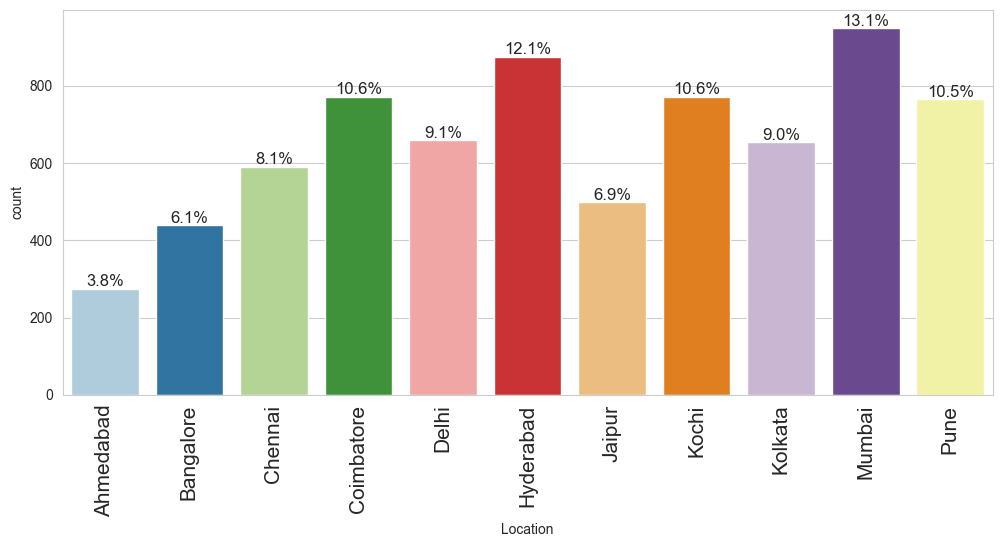

<Figure size 1000x500 with 0 Axes>

In [124]:
labeled_barplot(data=data, feature='Location', perc=True)

Observations:

- Mumbai, Hyderabad, Coimbatore, Kochi ,Pune,Delhi,Kolkata,Chennai,Jaipur, and Bangalore are the most representative cities int th data set 


### Year

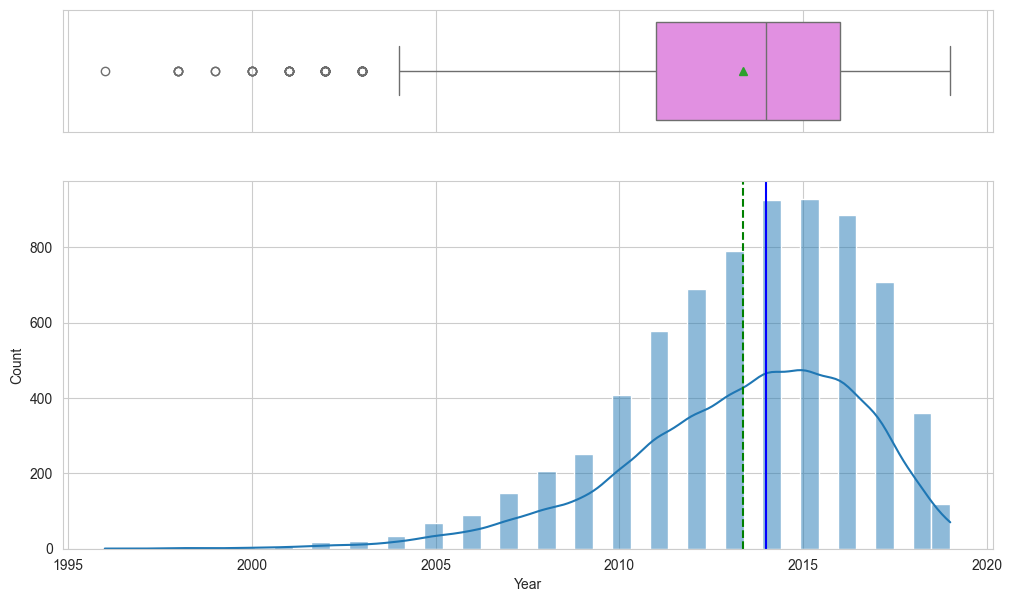

In [125]:
histogram_boxplot(data=data, feature='Year', kde=True)

Observations:

- This feature is left skew and has outliers 

### Kilometers_driven

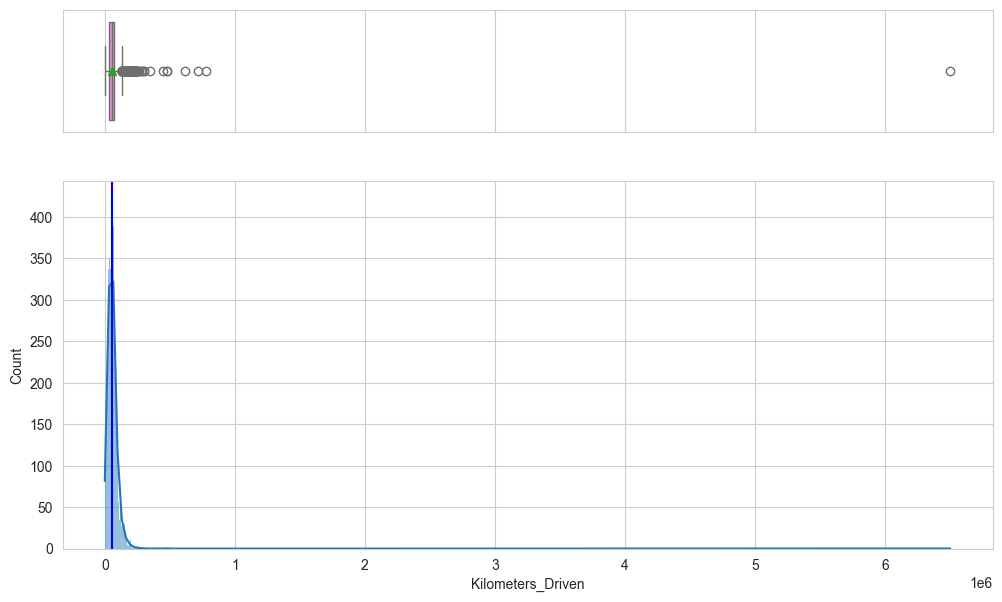

In [126]:
histogram_boxplot(data=data, feature='Kilometers_Driven', kde=True)


Observations:

- The distribution is right-skewed. This means most cars have a relatively low to medium number of kilometers, while a few cars (the outliers) have an extremely high number.This is a problem because the extreme outlier values can have a disproportionate influence on some machine learning models, effectively "pulling" the model's predictions towards them and reducing overall accuracy.

### Fuel_Type

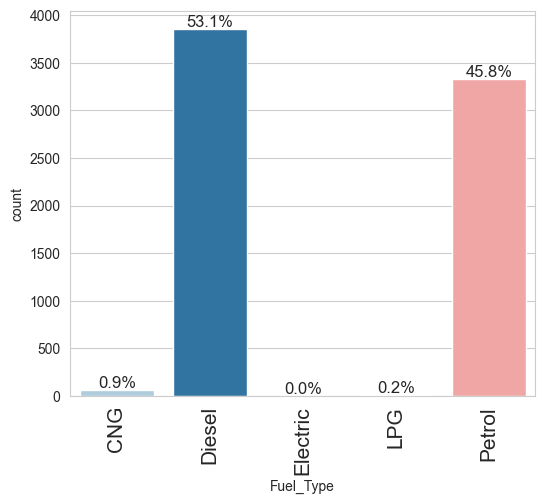

<Figure size 1000x500 with 0 Axes>

In [127]:
labeled_barplot(data=data,feature='Fuel_Type', perc=True)

Observations:

- Petrol and Diesel are the most recurrent 
- Petrol: (Gasoline) 
    - Running Cost: Moderate	Smooth
    - balanced performance
    - The most common, standard option.
- Diesel	
    - Low to Moderate	
    - High torque, good for highways	
    - Excellent fuel efficiency, but potentially higher maintenance.
- CNG / LPG	Very Low	
    - Can be slightly lower than petrol	
    - Drastically cheaper to run; the tank can take up trunk space.
- Electric	
    - Running Cost Lowest	
    - Instant torque, very quick & silent	
    - Zero tailpipe emissions; resale value depends heavily on battery health.

### Transmission


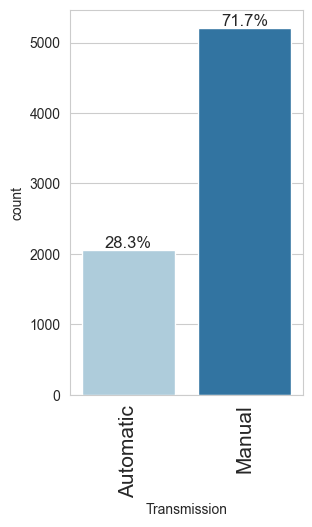

<Figure size 1000x500 with 0 Axes>

In [128]:
labeled_barplot(data=data, feature='Transmission', perc=True)

Observations:

- Manual Transmission has the most presence in the dataset 

### Owner

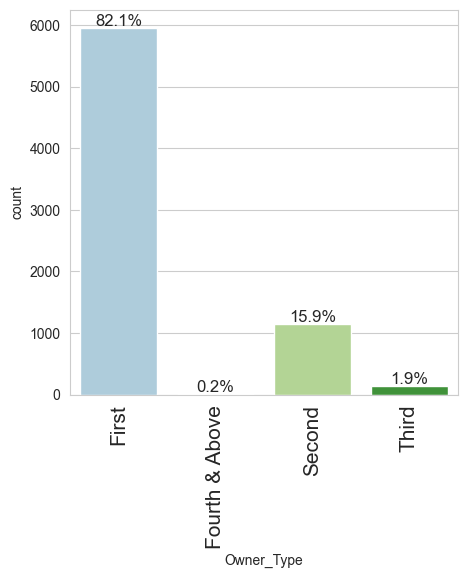

<Figure size 1000x500 with 0 Axes>

In [129]:
labeled_barplot(data=data, feature='Owner_Type', perc=True)

Observations:
- First Owner The most desirable category. The seller bought the car brand new. This suggests a complete service history and that the car was likely well-maintained as a major personal investment.

- Second Owner: Still very good. This means the car has only been sold once before. This is a very common and acceptable history for most used cars.

- Third Owner This starts to raise some questions. With two previous owners, the car's maintenance history may become less clear, and the reasons for being sold multiple times are unknown.

- Fourth & Above Owner This is often a red flag for buyers. A car that has been passed through many hands may have recurring mechanical problems or a history of neglect. The risk is significantly higher.

### Mileage

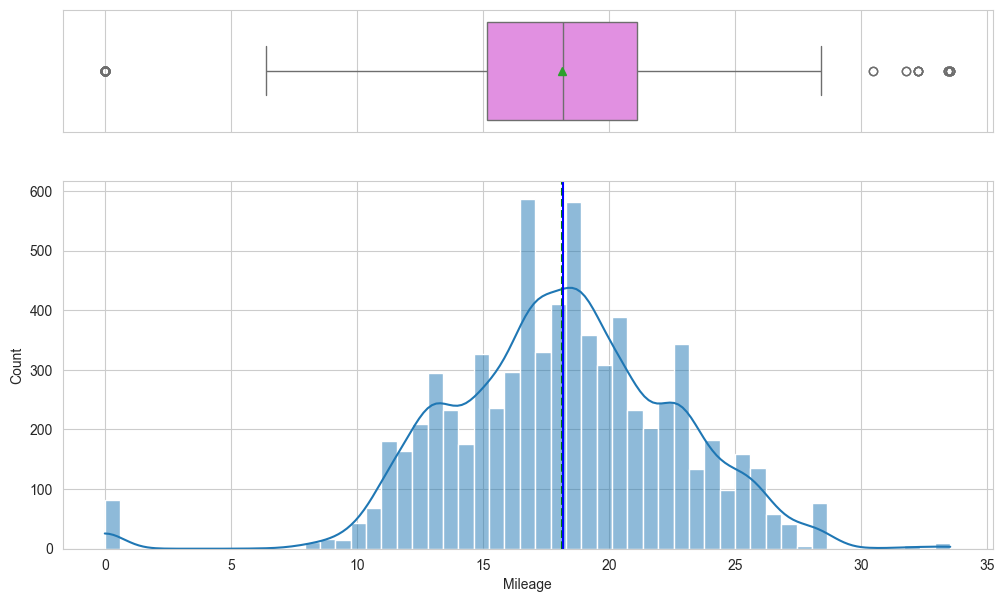

In [130]:
histogram_boxplot(data=data, feature='Mileage', kde=True)

Observations:

- The feature is close to a normal distribution 

### Engine



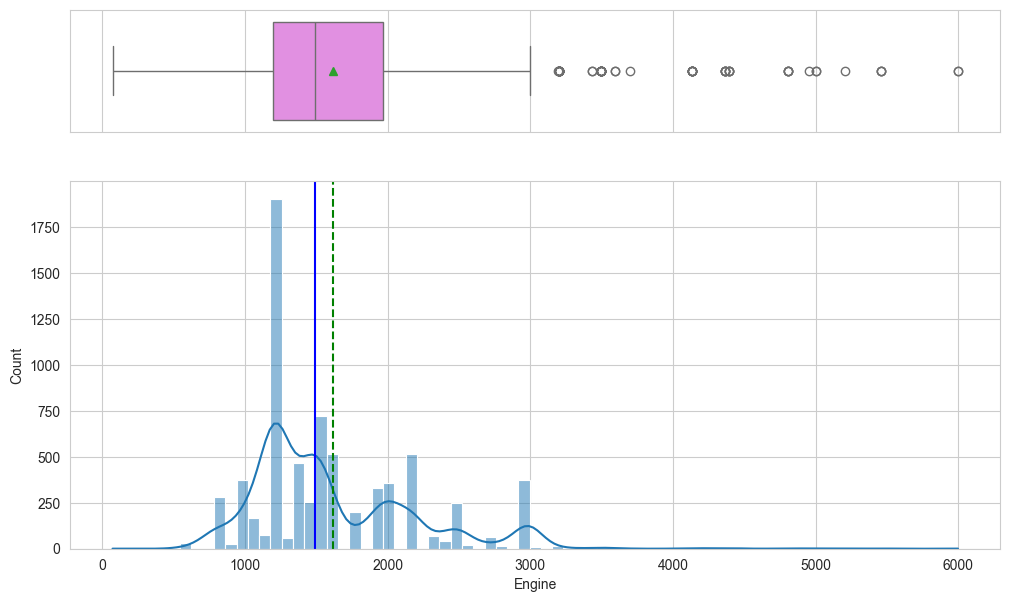

In [131]:
histogram_boxplot(data=data, feature='Engine', kde=True)

Observations:

- This feature shows a multimodal distribution with outliers


### Power

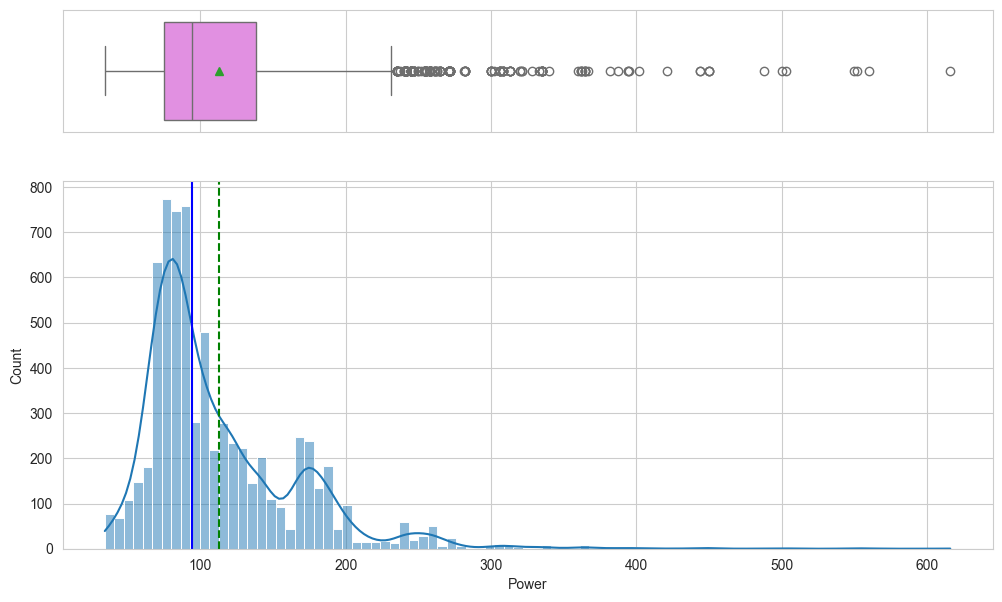

In [132]:
histogram_boxplot(data=data, feature='Power', kde=True)

Observations:

- This feature has outliers and skew to the right 

### Seats

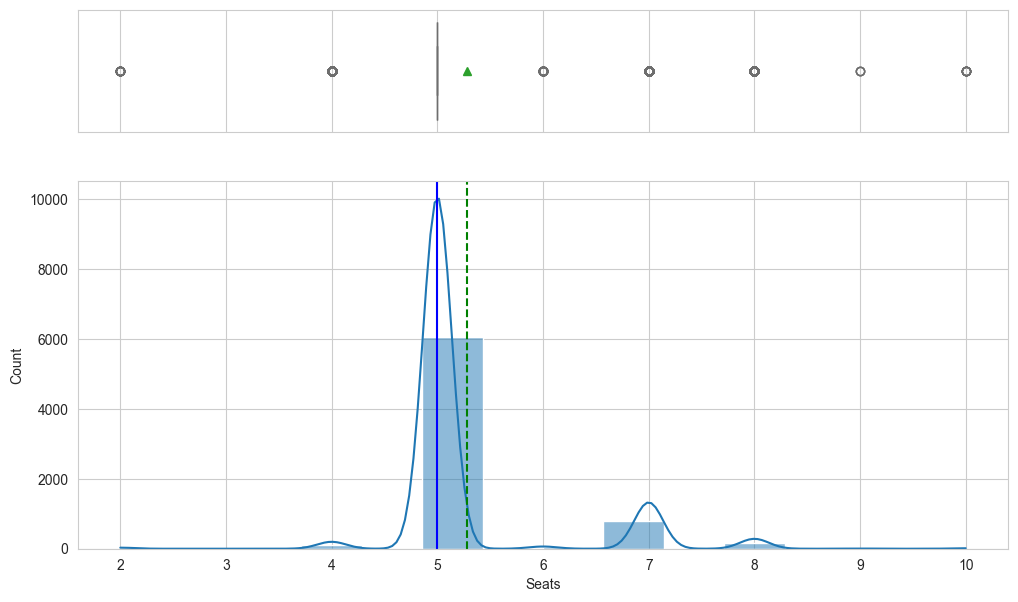

In [133]:
histogram_boxplot(data=data, feature='Seats', kde=True)

Observations:

- This has a multimodal distribution, cars with 5 seats are more present in this dataset 

### New_Price

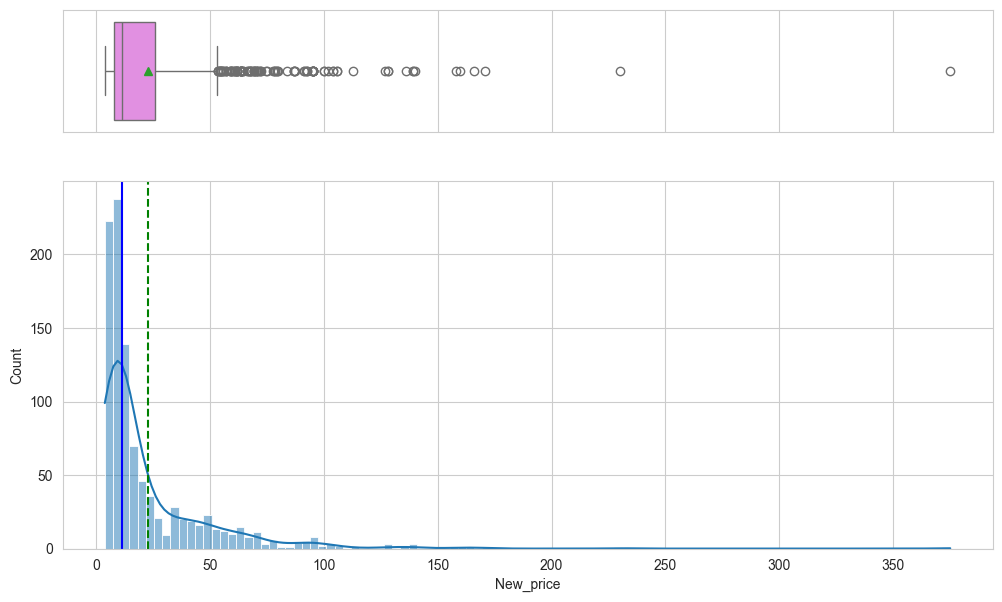

In [134]:
histogram_boxplot(data=data, feature='New_price', kde=True)


Observations:

- The distribution is right skew to the right with extreme values 

### Price

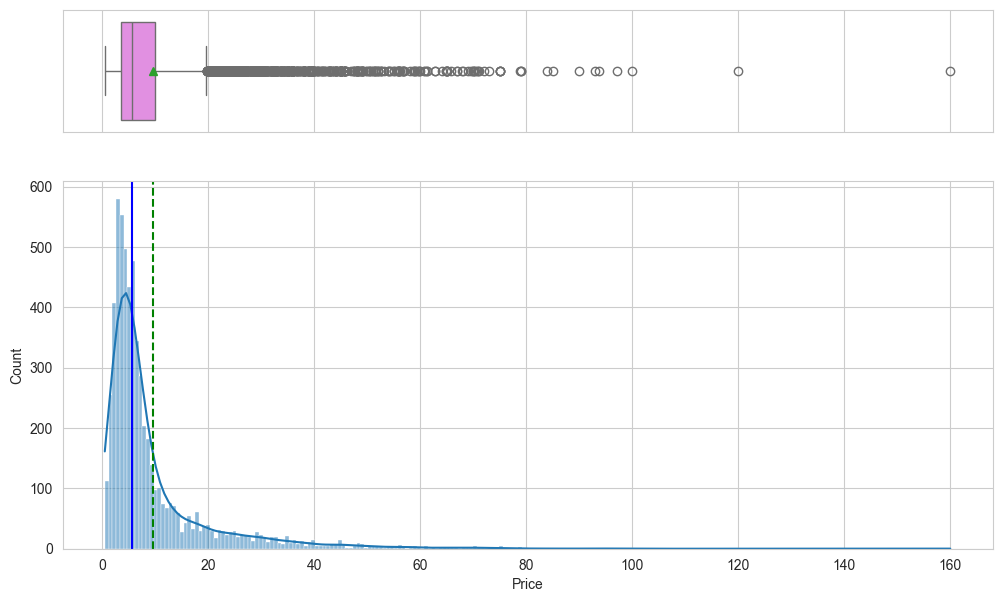

In [135]:
histogram_boxplot(data=data, feature='Price', kde=True)

Observations:

- This feaure is skew and has outliers this is the target variable 

## Data Preprocessing Univariate 

### Create new features BranName and BrandModel

In [136]:
# drop Name feature and create new categorical feautures from the name
data['BrandName'] = data['Name'].apply(lambda row_: row_[: row_.find(' ')])
data['BrandModel'] = data['Name'].apply(lambda row_: row_[row_.find(' ') + 1: ])


In [137]:
#data.BrandName.value_counts().reset_index(name='count')


In [138]:
# Change datatype to category 
categorical_columns = ['Transmission', 'Fuel_Type', 'Owner_Type', 'BrandName', 'Location']

def categorical_features(categorical_columns: list):
    for column in categorical_columns:
        data[column] = data[column].astype('category')
        
categorical_features(categorical_columns)
data.drop(columns=['S.No.'], inplace=True) # Droping serial number 


Observations:

- Since the target variable is Price we can not inpute the value we are trying to predict we would end up creating fake data 


**Questions:**

1. Do univariate analysis for numerical and categorical variables?
2. Check the distribution of the different variables? is the distributions skewed?
3. Do we need to do log_transformation, if so for what variables we need to do?
4. Perfoem the log_transformation(if needed) and write down your observations?

## **Bivariate Analysis**

### Correlation Analysis

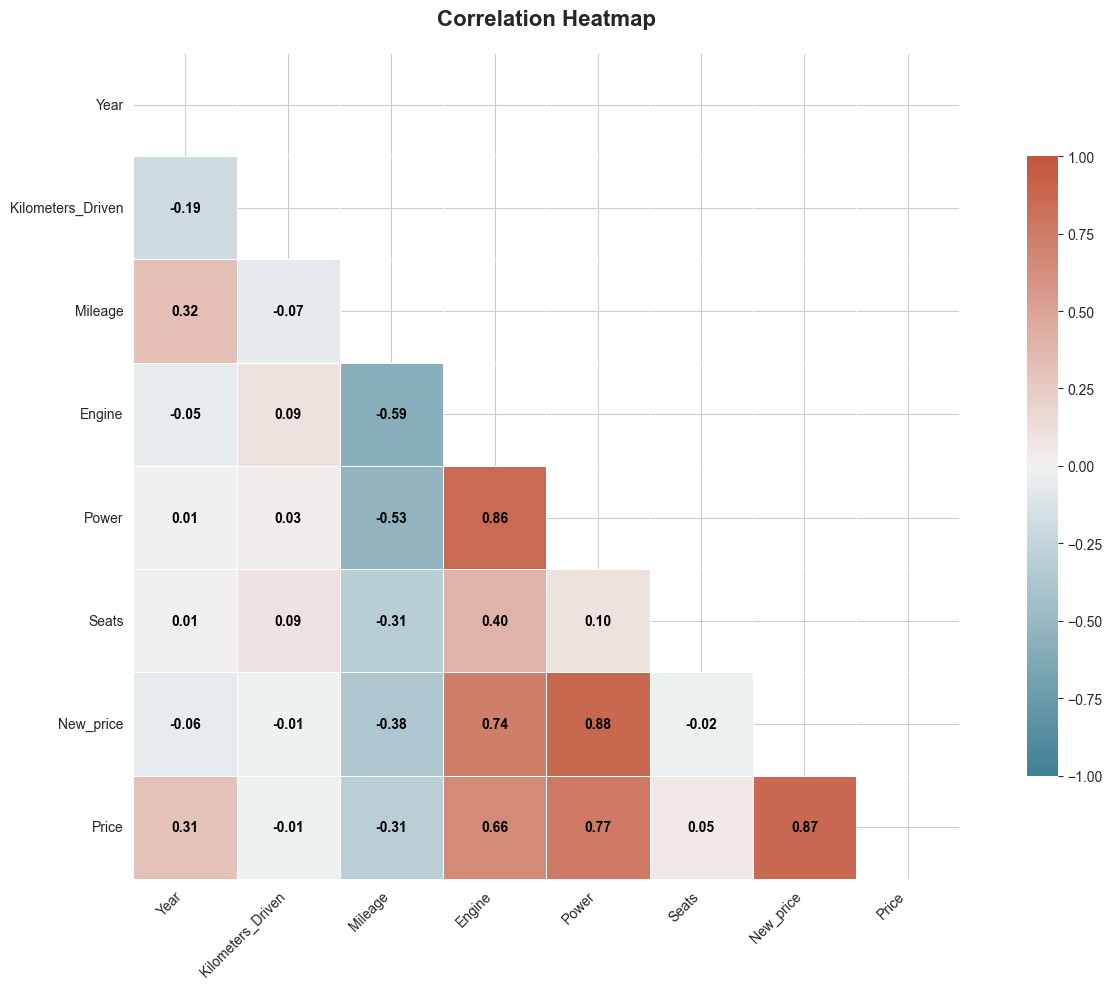

In [139]:
correlation_heatmap(df=data)

Observations:

- Year is somehow correlated with Price
- Kilometers_Driven has a negative correlation with Year and Price , means the more years the less value for the car, 
- Mileage is also negative correlated means the more mileage the less value , 
- Engine has a moderate correlation, that makes sense the more power the cost increases 
- Seats has a moderate correlation with Engine suggest the bigger the engine the power uses to support more people 
- New_price: has a strong correlation with Price , means we need to perform PCA or drow the column, this one is also correlated with Engine and Power 
- Power: Strong correlation with Engine 
- Price: Has a strong correlation with ENgine, Power and New_Price 

### Distribution of Numerical Predictors vs Target feature

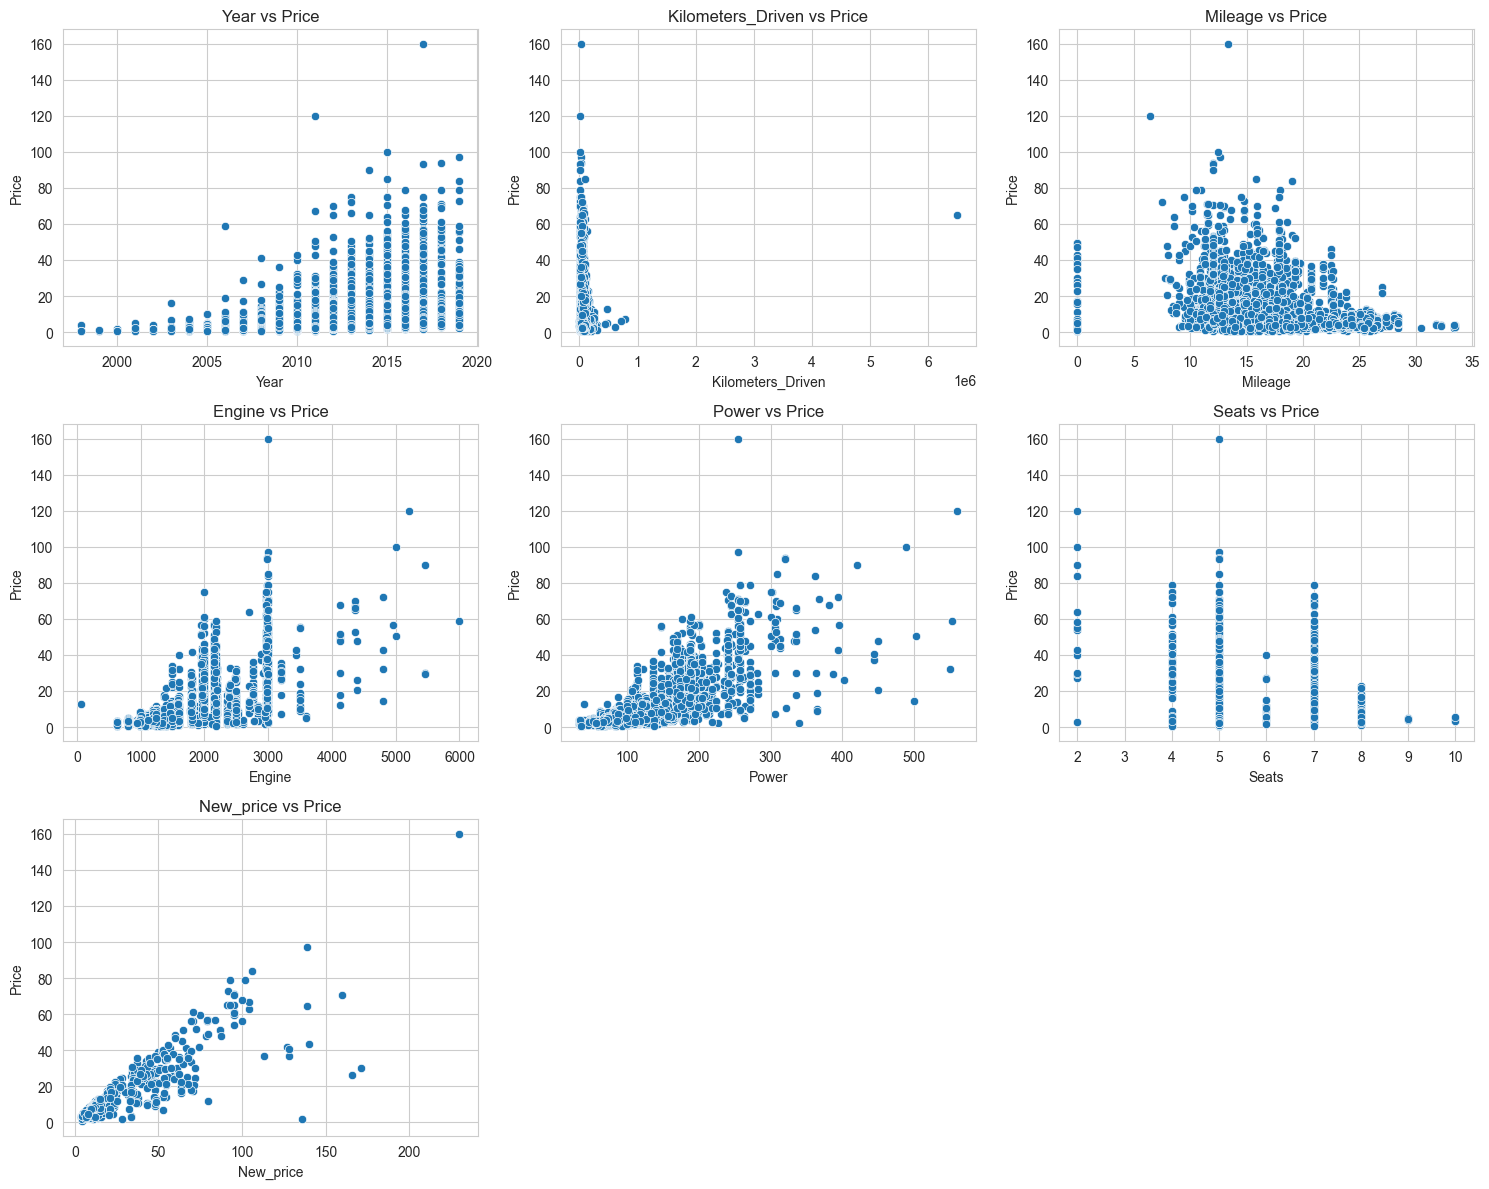

In [140]:

bivariate_numtype = data.drop(columns=['Transmission', 'Fuel_Type', 'Owner_Type', 'Name','BrandName','BrandModel', 'Location']) # Droping categoriacal features 
scatter_plot_grid_features_vs_target( df=bivariate_numtype, target_col= 'Price' )

### Boxplot Target variable VS Location

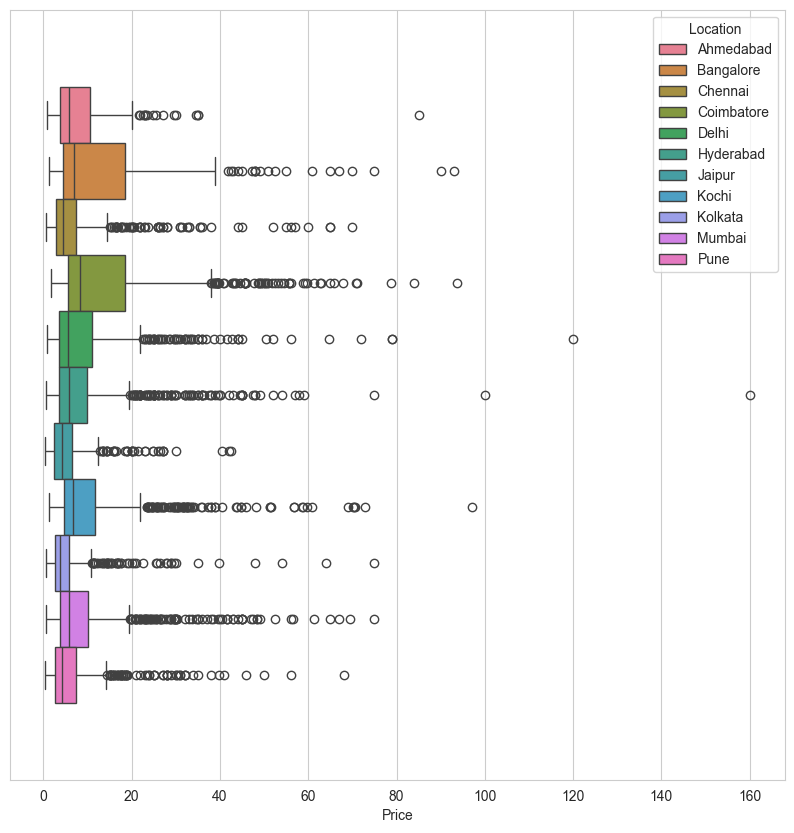

In [141]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data, x='Price', hue='Location')
plt.show()

Observations:

- Bangalore is the city with more vehicles follow by coimbatore

### Boxplot Target variable VS Transmission

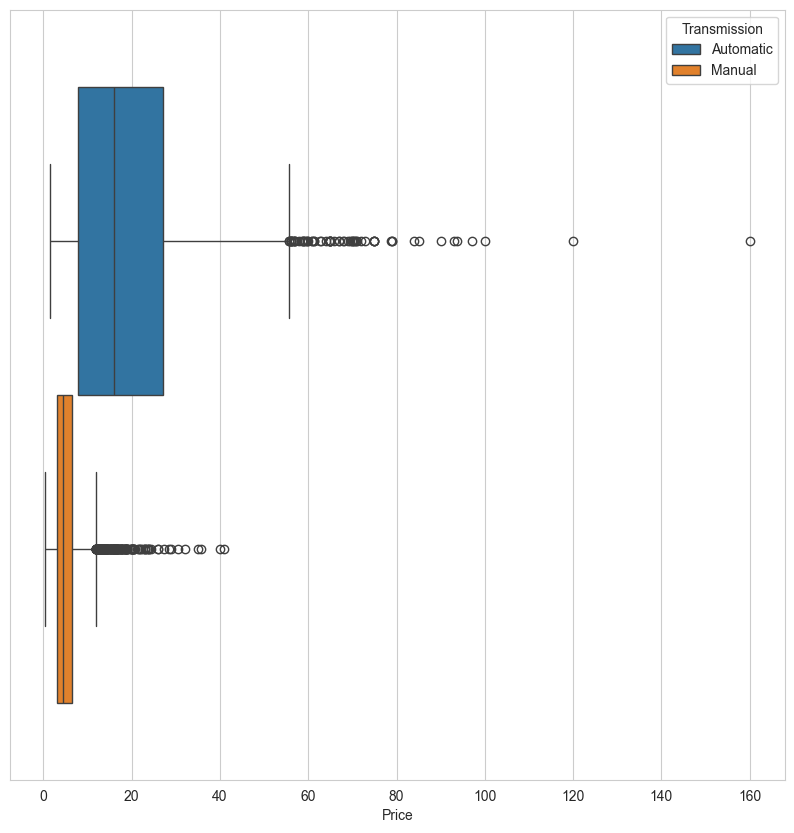

In [142]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data, x='Price', hue='Transmission')
plt.show()

Observations:

- There are more automatic cars indicating this type of vehicle is the most popular in the market 


### Data Preprocession Bivariate 

#### **Missing value treatment**


In [143]:
print("Missing values before treatment:")
data.isnull().sum().reset_index(name='count').sort_values(by='count', ascending=False)

Missing values before treatment:


,index,count
11,New_price,6247
12,Price,1234
9,Power,175
10,Seats,53
8,Engine,46
7,Mileage,2
0,Name,0
1,Location,0
2,Year,0
3,Kilometers_Driven,0


In [144]:
# cols with missing values ['New_price_Log1','Price', 'Power','Seats','Engine','Mileage']
# handle missing values in the target variable
# dropping the rows where the target variable is missing is the only correct and safe option
# Price


# New_price
imputed_values_new_price = data.groupby(['BrandName', 'BrandModel'])['New_price'].transform('mean')
data['New_price'].fillna(imputed_values_new_price, inplace=True)
if data['New_price'].isna().sum() > 0:
    data['New_price'].fillna(data['New_price'].mean(), inplace= True)

# Power
impute_values_power = data.groupby(['BrandName', 'BrandModel'])['Power'].transform('mean')
data['Power'].fillna(impute_values_power, inplace=True)
if data['Power'].isnull().sum() > 0 :
    data['Power'].fillna(data['Power'].mean(), inplace=True)
    
# Mileage 
impute_values_mileage = data.groupby(['BrandName', 'BrandModel'])['Mileage'].transform('mean')
data['Mileage'].fillna(impute_values_mileage, inplace=True)
if data['Mileage'].isnull().sum() > 0:
    data['Mileage'].fillna(data['Mileage'].mean(), inplace=True)

# Engine I'm using mean since categorical 
impute_values_engine= data.groupby(['BrandName', 'BrandModel'])['Engine'].transform('mean')
data['Engine'].fillna(impute_values_engine, inplace=True)
if data['Engine'].isnull().sum() > 0:
    data['Engine'].fillna(data['Engine'].mean(), inplace=True)

# Seats # Impute these missing values one by one, by taking median number of seats for the particular car, using the Brand and Model name.

imputed_values_seats = data.groupby(['BrandName', 'BrandModel'])['Seats'].transform(lambda x: x.mode()[0] if not x.mode().empty else None)
data['Seats'].fillna(imputed_values_seats, inplace=True)
if data['Seats'].isna().sum() > 0:
    data['Seats'].fillna(data['Seats'].mode()[0], inplace= True)   

# # Verify that there are no more missing values
print("Missing values after treatment:")
data.isnull().sum().reset_index(name='count').sort_values(by='count', ascending=False)


Missing values after treatment:


,index,count
12,Price,1234
0,Name,0
1,Location,0
2,Year,0
3,Kilometers_Driven,0
4,Fuel_Type,0
5,Transmission,0
6,Owner_Type,0
7,Mileage,0
8,Engine,0


#### **Skewed Features**


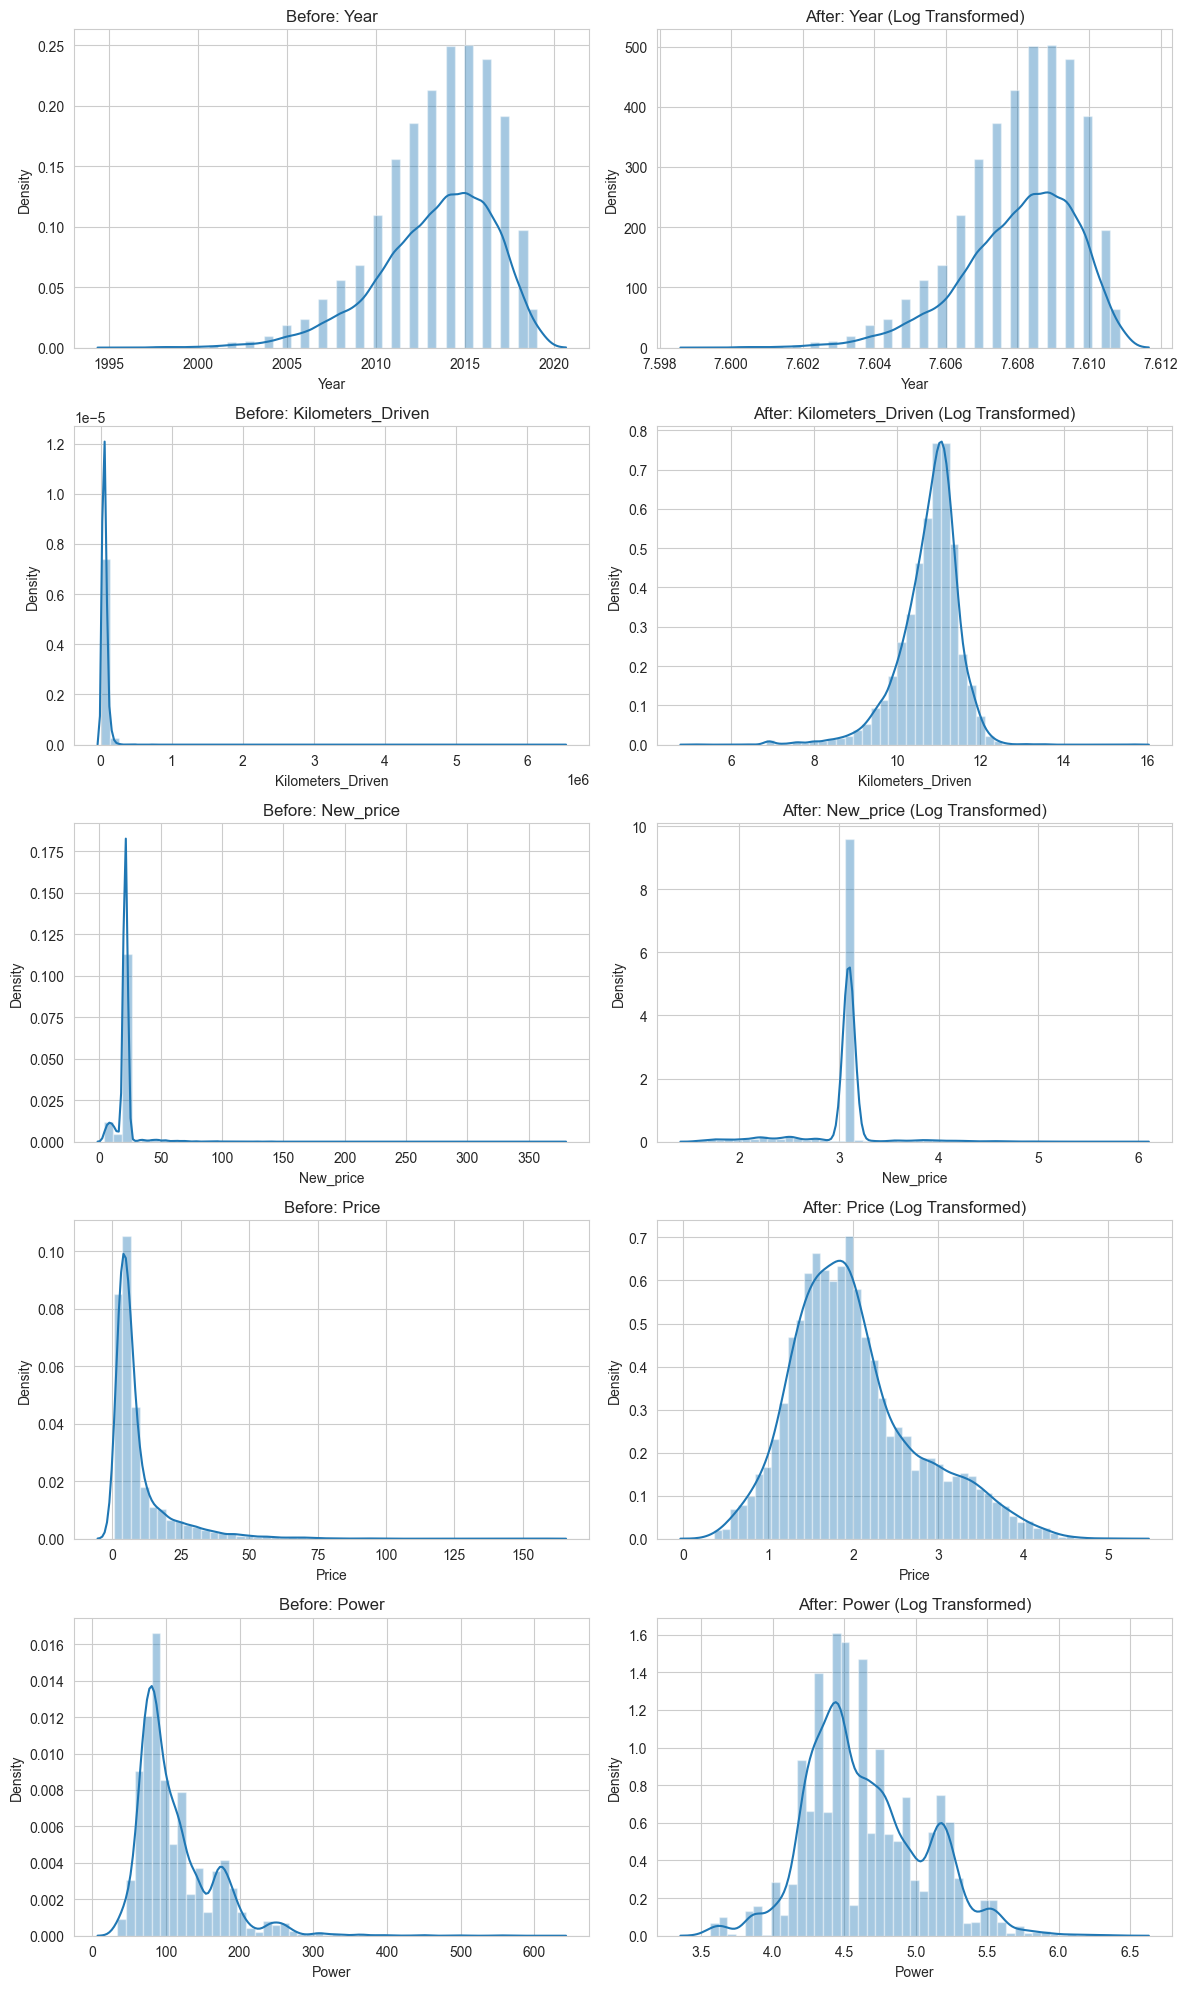

In [145]:
skew_columns = ['Year', 'Kilometers_Driven', 'New_price', 'Price', 'Power']

dist_plot_grid_log1_before_after_transformation(skew_columns)
    
    

Observations:

- The log transformation did not help for the Year column I'm excluding it 

In [146]:
skew_columns.remove('Year')
log1_skew_columns(data, skew_columns)

#### New Feature AGE

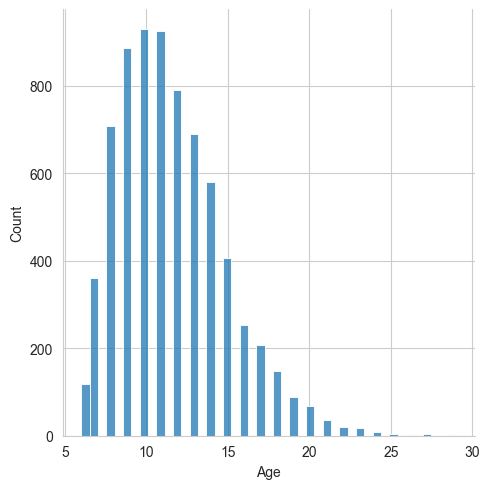

In [147]:
data['Age'] = data['Year'].apply(lambda x: 2025 - x) # Getting the Car Age 
data.drop(columns=['Year'], inplace=True)
sns.displot(data, x='Age')

Perform feature engineering
- Perhaps logtransforms since these features are skewed , Year kilometers_driven New_price and Power
- drop serial number
- Create new features from Name colum 
- Perform One hot encoding: ['Transmission', 'Fuel_Type', 'Owner_Type']
- Owner_Type = ordinal category feature,  mapping the categories to numbers that preserve their order: First → 1 Second → 2 Third → 3 Fourth & Above → 4
- Treat missing values
- Replace Kilometers_Driven for a log transform feature 

### **Questions:**

1. Plot a scatter plot for the log transformed values(if log_transformation done in previous steps)? Done, Skewed Section 
2. What can we infer form the correlation heatmap? Is there correlation between the dependent and independent variables? Done observation in the correlation section 
3. Plot a box plot for target variable and categorical variable 'Location' and write your observations? Done observation in the Location and Price plot - Bivariate section 

## **Important Insights from EDA and Data Preprocessing**

Key Observations from Exploratory Data Analysis (EDA)

Price and Mileage are Heavily Skewed: The distributions for Price, New_price, and Kilometers_Driven are not normal bell curves. They are heavily right-skewed, meaning most cars have lower values, but a few have extremely high prices or kilometers. This tells us that standard statistical methods might be misled by these outliers.

Clear, Intuitive Relationships Exist:

    - Negative Correlation: Price strongly decreases as Kilometers_Driven and Age increase. This is the fundamental principle of depreciation.    
    - Positive Correlation: Price strongly increases with Power (BHP) and Engine size (CC). Performance and size are key drivers of value.    
    - Owner History is a Major Price Factor: There is a clear hierarchy of value. First Owner cars command the highest prices, and the value drops significantly with each subsequent owner. This confirms that vehicle history and perceived risk are critical to buyers.    
    - Fuel Type and Transmission Matter: There are distinct price differences between fuel types. Diesel cars, for example, often have a different price structure than Petrol cars due to their fuel efficiency and torque. Similarly, Automatic transmissions are priced differently than Manuals, reflecting market preferences.
    - Data Quality Issues Need to be Addressed: The dataset contains significant missing values, especially in columns like New_price, Seats, and Power. These must be handled intelligently to avoid losing valuable data.

Key Data Preprocessing Decisions
Based on the observations, I established a clear strategy for cleaning and preparing the data for a machine learning model.

    - Handling Skewness with Log Transformation: The most important preprocessing step is to apply a log transformation (specifically np.log1p) to the skewed features like Price and Kilometers_Driven. This corrects the skew, normalizes the distribution, and helps the model perform better.
    - Smart Imputation for Missing Values: Instead of a one-size-fits-all approach, we will use targeted methods:
        - Seats: Impute using the mode number of seats from cars of the same brand and model, a highly accurate approach.
        - New_Price, Power, Engine, Mileage: Imputing the mean of each feachure from cars of the same brand and model, which is robust to outliers.
        - Price (Target Variable): Any rows with a missing Price will be dropped, as we cannot "guess" the value we are trying to predict.

Correct Encoding for Categorical Features:

    - Owner_Type: This is an ordinal feature with a clear ranking. We will use Ordinal Encoding (e.g., First=1, Second=2) to preserve this valuable information.
    - Fuel_Type & Transmission: These are nominal features with no inherent order. One-Hot Encoding is the correct choice here.
    - Location: This is a high-cardinality feature. A simple One-Hot Encoding would be inefficient. A more advanced method like Target Encoding is required.
    - Feature Engineering: A crucial new feature, Age, will be created by subtracting the car's Year of manufacture from the current year. This is often more predictive than the year itself.
    - Creating a feature for the average price sold by a brand is a powerful way to capture the brand's market value. Target Encoding, converts a simple brand name into a potent numerical feature that directly reflects its market position (e.g., luxury, economy, mid-range).

**Question:** 

1. Why we should drop 'Name','Price','price_log','Kilometers_Driven' from X before splitting?:
    - Price and price_log (The Target Variable) This is the most critical rule. The Price column (and its log-transformed version) is the target variable—it's the answer I want the model to predict.
    -  The main goals are to prevent data leakage and to use only the most effective version of your features.
    - The Name column (e.g., "Maruti Suzuki Swift Dzire VDI") is dropped for two main reasons:
        - High Cardinality: This feature has too many unique values. Using One-Hot Encoding on it would create thousands of new columns, making your model inefficient and likely to overfit.
        - Redundancy: The useful information inside the Name column—like the brand ("Maruti Suzuki") and the model ("Swift")—has  been extracted into separate, cleaner features like Brand and Model. Once this information is captured, the original Name column is redundant.
    -  Kilometers_Driven column is dropped only after I created a better one , transformed version of it, Kilometers_Driven_log.

In [148]:
data.head()

,Name,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_price,Price,BrandName,BrandModel,Kilometers_Driven_Log1,New_price_Log1,Price_Log1,Power_Log1,Age
0,Maruti Wagon R LXI CNG,Mumbai,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,21.225561,1.75,Maruti,Wagon R LXI CNG,11.184421,3.055206,0.559616,4.063198,15
1,Hyundai Creta 1.6 CRDi SX Option,Pune,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,21.225561,12.50,Hyundai,Creta 1.6 CRDi SX Option,10.621327,3.055206,2.525729,4.837868,10
2,Honda Jazz V,Chennai,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.610000,4.50,Honda,Jazz V,10.736397,2.152924,1.504077,4.485260,14
3,Maruti Ertiga VDI,Chennai,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,11.128750,6.00,Maruti,Ertiga VDI,11.373663,2.409532,1.791759,4.485936,13
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,21.225561,17.74,Audi,A4 New 2.0 TDI Multitronic,10.613246,3.055206,2.875822,4.947340,12


# **Building Various Models**  🧠


1. What we want to predict is the "Price". We will use the normalized version 'price_log' for modeling.
2. Before we proceed to the model, we'll have to encode categorical features. We will drop categorical features like Name. 
3. We'll split the data into train and test, to be able to evaluate the model that we build on the train data.
4. Build Regression models using train data.
5. Evaluate the model performance.

### **Split the Data**

<li>Step1: Seperating the indepdent variables (X) and the dependent variable (y). 
<li>Step2: Encode the categorical variables in X using pd.dummies.
<li>Step3: Split the data into train and test using train_test_split.

### Droping before split

In [149]:
data.drop(columns=['Location'], inplace=True)

In [150]:
#  Dropping NaN Values in price 
data.dropna(subset=['Price'], inplace=True)  

In [151]:
# Dropping skew columns 
print(f"Skew Columns: {skew_columns}")
data.drop(columns=skew_columns, inplace=True)

Skew Columns: ['Kilometers_Driven', 'New_price', 'Price', 'Power']


In [152]:
# Drop Brandmodel

data.drop(columns=['BrandModel'], inplace=True)

In [153]:
# Droping Name
data.drop(columns=['Name'], inplace=True)

In [154]:
data.head()

,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,BrandName,Kilometers_Driven_Log1,New_price_Log1,Price_Log1,Power_Log1,Age
0,CNG,Manual,First,26.60,998.0,5.0,Maruti,11.184421,3.055206,0.559616,4.063198,15
1,Diesel,Manual,First,19.67,1582.0,5.0,Hyundai,10.621327,3.055206,2.525729,4.837868,10
2,Petrol,Manual,First,18.20,1199.0,5.0,Honda,10.736397,2.152924,1.504077,4.485260,14
3,Diesel,Manual,First,20.77,1248.0,7.0,Maruti,11.373663,2.409532,1.791759,4.485936,13
4,Diesel,Automatic,Second,15.20,1968.0,5.0,Audi,10.613246,3.055206,2.875822,4.947340,12


In [155]:


# 1. Define Features (X) and Target (y)
X = data.drop(columns=['Price_Log1'])
y = data['Price_Log1']

# 2. Split into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



### Target Encoding  categorical 

In [156]:
# Create the map (a pandas Series) from the training data
brand_price_map = X_train.join(y_train).groupby('BrandName')['Price_Log1'].mean()

# Create the new feature
X_train['Avg_Price_By_Brand'] = X_train['BrandName'].map(brand_price_map)
X_test['Avg_Price_By_Brand'] = X_test['BrandName'].map(brand_price_map)

# Fill any potential NaNs in the test set with the global average price from training
global_mean_price = y_train.mean()
X_test['Avg_Price_By_Brand'].fillna(global_mean_price, inplace=True)

In [157]:
# Check if I have brandnames in the train set that I dont have in the test set 
X_test.isnull().sum()

Fuel_Type                 0
Transmission              0
Owner_Type                0
Mileage                   0
Engine                    0
Seats                     0
BrandName                 0
Kilometers_Driven_Log1    0
New_price_Log1            0
Power_Log1                0
Age                       0
Avg_Price_By_Brand        0
dtype: int64

In [158]:
# Drop the original column from both sets
X_train.drop('BrandName', axis=1, inplace=True)
X_test.drop('BrandName', axis=1, inplace=True)

In [159]:
X_test.head()

,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Kilometers_Driven_Log1,New_price_Log1,Power_Log1,Age,Avg_Price_By_Brand
2868,Diesel,Manual,First,23.4,1248.000000,5.0,11.141862,3.055206,4.304065,12,1.375185
5924,Diesel,Manual,First,15.4,1997.000000,7.0,10.193953,3.055206,4.787492,8,1.967382
3764,Diesel,Manual,First,15.1,2179.000000,7.0,11.362103,3.055206,4.941642,11,1.967382
4144,Diesel,Manual,Second,25.0,1396.000000,5.0,10.858999,3.055206,4.234251,9,0.978936
2780,Petrol,Manual,First,0.0,1616.347706,5.0,11.512925,3.055206,4.723421,16,1.490467


In [160]:
X_train.head()

,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Kilometers_Driven_Log1,New_price_Log1,Power_Log1,Age,Avg_Price_By_Brand
4201,Diesel,Manual,First,22.07,1199.0,5.0,11.251561,3.055206,4.302713,14,1.604696
4383,Petrol,Manual,First,20.36,1197.0,5.0,9.900834,3.055206,4.368181,9,1.490467
1779,Diesel,Manual,First,15.10,2179.0,7.0,11.169914,3.055206,4.941642,11,1.967382
4020,Diesel,Manual,First,25.20,1248.0,5.0,11.654382,3.055206,4.304065,12,1.375185
3248,Petrol,Manual,First,16.47,1198.0,5.0,10.981080,3.055206,4.302713,14,1.604696


### Encoding  Ordinal categorical 

In [161]:
# 
# Ordinal Category 
# Create the explicit mapping for the order
owner_mapping = {
    'First': 1,
    'Second': 2,
    'Third': 3,
    'Fourth & Above': 4
}
# Ordinal Category Feature
# Apply mapping in Owner Type
X_train['Owner_Type'] =  X_train['Owner_Type'].map(owner_mapping)
X_test['Owner_Type'] =  X_test['Owner_Type'].map(owner_mapping)



In [162]:
X_test.head()

,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Kilometers_Driven_Log1,New_price_Log1,Power_Log1,Age,Avg_Price_By_Brand
2868,Diesel,Manual,1,23.4,1248.000000,5.0,11.141862,3.055206,4.304065,12,1.375185
5924,Diesel,Manual,1,15.4,1997.000000,7.0,10.193953,3.055206,4.787492,8,1.967382
3764,Diesel,Manual,1,15.1,2179.000000,7.0,11.362103,3.055206,4.941642,11,1.967382
4144,Diesel,Manual,2,25.0,1396.000000,5.0,10.858999,3.055206,4.234251,9,0.978936
2780,Petrol,Manual,1,0.0,1616.347706,5.0,11.512925,3.055206,4.723421,16,1.490467


In [163]:
X_train.head()

,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Kilometers_Driven_Log1,New_price_Log1,Power_Log1,Age,Avg_Price_By_Brand
4201,Diesel,Manual,1,22.07,1199.0,5.0,11.251561,3.055206,4.302713,14,1.604696
4383,Petrol,Manual,1,20.36,1197.0,5.0,9.900834,3.055206,4.368181,9,1.490467
1779,Diesel,Manual,1,15.10,2179.0,7.0,11.169914,3.055206,4.941642,11,1.967382
4020,Diesel,Manual,1,25.20,1248.0,5.0,11.654382,3.055206,4.304065,12,1.375185
3248,Petrol,Manual,1,16.47,1198.0,5.0,10.981080,3.055206,4.302713,14,1.604696


### One Hot encoding  categorical 

In [164]:
 # Define which columns to encode and create the encoder
cols_to_encode = ['Fuel_Type', 'Transmission']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the TRAINING data and transform BOTH sets
# Fit AND transform the training data
X_train_encoded = encoder.fit_transform(X_train[cols_to_encode])

# ONLY transform the testing data (it uses the categories learned from train)
X_test_encoded = encoder.transform(X_test[cols_to_encode])

# 4. Create new DataFrames with the encoded columns
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(cols_to_encode), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(cols_to_encode), index=X_test.index)


# 5. Drop the original columns and concatenate the new ones
X_train_processed = pd.concat([X_train.drop(cols_to_encode, axis=1), X_train_encoded_df], axis=1)
X_test_processed = pd.concat([X_test.drop(cols_to_encode, axis=1), X_test_encoded_df], axis=1)


print("### Processed Training Data Head:")
X_train_processed.head()

### Processed Training Data Head:


,Owner_Type,Mileage,Engine,Seats,Kilometers_Driven_Log1,New_price_Log1,Power_Log1,Age,Avg_Price_By_Brand,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual
4201,1,22.07,1199.0,5.0,11.251561,3.055206,4.302713,14,1.604696,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4383,1,20.36,1197.0,5.0,9.900834,3.055206,4.368181,9,1.490467,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1779,1,15.10,2179.0,7.0,11.169914,3.055206,4.941642,11,1.967382,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4020,1,25.20,1248.0,5.0,11.654382,3.055206,4.304065,12,1.375185,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3248,1,16.47,1198.0,5.0,10.981080,3.055206,4.302713,14,1.604696,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [165]:
X_test_processed.head()

,Owner_Type,Mileage,Engine,Seats,Kilometers_Driven_Log1,New_price_Log1,Power_Log1,Age,Avg_Price_By_Brand,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual
2868,1,23.4,1248.000000,5.0,11.141862,3.055206,4.304065,12,1.375185,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5924,1,15.4,1997.000000,7.0,10.193953,3.055206,4.787492,8,1.967382,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3764,1,15.1,2179.000000,7.0,11.362103,3.055206,4.941642,11,1.967382,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4144,2,25.0,1396.000000,5.0,10.858999,3.055206,4.234251,9,0.978936,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2780,1,0.0,1616.347706,5.0,11.512925,3.055206,4.723421,16,1.490467,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### **Linear Regression**

For Regression Problems, some of the algorithms used are :<br>

**1) Linear Regression** <br>
**2) Ridge / Lasso Regression** <br>
**3) Decision Trees** <br>
**4) Random Forest** <br>

In [166]:
lr = LinearRegression()
# Train the model
lr.fit(X_train_processed, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Model Evaluation  🧐

In [167]:

# 
# --- Evaluate Training Performance ---
train_perf_lr = model_performance_regression(lr, X_train_processed, y_train)
train_perf_lr['Model Name'] = 'train_perf_lr'
print("Training Performance:")
print(train_perf_lr)

# --- Evaluate Testing Performance ---
test_perf_lr = model_performance_regression(lr, X_test_processed, y_test)
test_perf_lr['Model Name'] = 'test_perf_lr'
print("\nTesting Performance:")
print(test_perf_lr)

Training Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE     Model Name
0  0.256377  0.198277   0.912657        0.912324   inf  train_perf_lr

Testing Performance:
       RMSE     MAE  R-squared  Adj. R-squared  MAPE    Model Name
0  0.279265  0.2086   0.901299        0.900416   inf  test_perf_lr


In [168]:
model_metrics = []
model_metrics.extend([test_perf_lr])
model_metrics


[       RMSE     MAE  R-squared  Adj. R-squared  MAPE    Model Name
 0  0.279265  0.2086   0.901299        0.900416   inf  test_perf_lr]

#### Making Predictions

Observations:

Since the target variable y was log-transformed, we need to convert the predictions back to their original scale to get an error in the actual currency (e.g., Dollars or Rupees). 
We do this using np.expm1(), the inverse of np.log1p().

In [169]:
# --- Evaluate on the original price scale (for MAE) ---
# Inverse transform both actual and predicted values
# Use the trained model to make predictions on the test set
y_pred_test = lr.predict(X_test_processed)
y_test_original = np.expm1(y_test)
y_pred_test_original = np.expm1(y_pred_test)

mae_test = mean_absolute_error(y_test_original, y_pred_test_original)

# Print the result in a user-friendly way
print(f"Test Mean Absolute Error (MAE): ${mae_test:,.2f}")
print(f"\nOn average, the model's price prediction is off by about ${mae_test:,.0f}.")


Test Mean Absolute Error (MAE): $1.97

On average, the model's price prediction is off by about $2.


#### Feature Importance

In [170]:
# Create a DataFrame to view the coefficients
coefficients_lr = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Model Coefficients ---")
print(coefficients_lr.sort_values(by='Coefficient', ascending=False))


--- Model Coefficients ---
                   Feature  Coefficient
11      Fuel_Type_Electric     0.915945
6               Power_Log1     0.687224
8       Avg_Price_By_Brand     0.428076
14  Transmission_Automatic     0.073935
5           New_price_Log1     0.031907
3                    Seats     0.014348
2                   Engine     0.000162
1                  Mileage    -0.004241
4   Kilometers_Driven_Log1    -0.034861
0               Owner_Type    -0.047359
15     Transmission_Manual    -0.073935
7                      Age    -0.122245
10        Fuel_Type_Diesel    -0.145386
12           Fuel_Type_LPG    -0.188290
9            Fuel_Type_CNG    -0.254485
13        Fuel_Type_Petrol    -0.327784


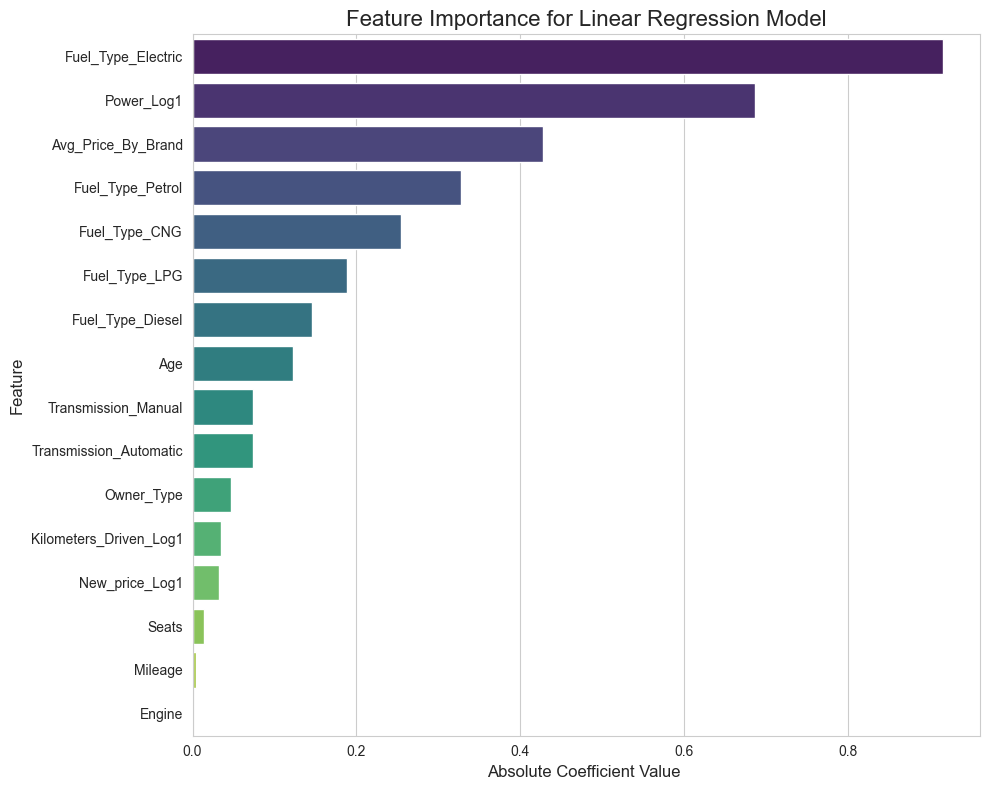

In [171]:
# --- Determine and Plot Feature Importance ---

# Create a DataFrame of feature names and their coefficients' absolute values
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': np.abs(lr.coef_)
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Linear Regression Model', fontsize=16)
plt.xlabel('Absolute Coefficient Value ', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() # Adjust layout to make sure labels fit
plt.show()


Observations:

- Good Fit: The metrics for the training and testing sets should be very close to each other. This indicates that your model generalizes well to new, unseen data.
- Overfitting: If the training scores (especially R-squared) are much better than the testing scores, the model has likely "memorized" the training data and is not good at making predictions on new data.
- In this case the results in the training set are a little bit better than the test set, but in general are closer to each other therefore this model generalize well
- This also shows the electric vehicles fuel type in particular fuel_type_electric has the biggest impact on the price prediction follow by power,  brand  ,  fuel_type 
- Engine and mileage are not important to predict the price 

### **Lasso**

In [172]:
# Create an instance of the Lasso model
# We'll start with a small alpha value
lasso = Lasso(alpha=0.001, random_state=42)

# Train the model on your processed training data
lasso.fit(X_train_processed, y_train)

,alpha,0.001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


#### Model Evaluation  🧐

In [173]:
# --- Evaluate Training Performance ---
train_perf_lasso = model_performance_regression(lasso, X_train_processed, y_train)
train_perf_lasso['Model Name'] = 'train_perf_lasso'
print("Lasso - Training Performance:")
print(train_perf_lasso)

# --- Evaluate Testing Performance ---
test_perf_lasso = model_performance_regression(lasso, X_test_processed, y_test)
test_perf_lasso['Model Name'] = 'test_perf_lasso'
print("\nLasso - Testing Performance:")
print(test_perf_lasso)

Lasso - Training Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE        Model Name
0  0.257098  0.198642   0.912165        0.911831   inf  train_perf_lasso

Lasso - Testing Performance:
       RMSE      MAE  R-squared  Adj. R-squared  MAPE       Model Name
0  0.280141  0.20918   0.900678         0.89979   inf  test_perf_lasso


In [174]:
model_metrics.extend([test_perf_lasso])
model_metrics

[       RMSE     MAE  R-squared  Adj. R-squared  MAPE    Model Name
 0  0.279265  0.2086   0.901299        0.900416   inf  test_perf_lr,
        RMSE      MAE  R-squared  Adj. R-squared  MAPE       Model Name
 0  0.280141  0.20918   0.900678         0.89979   inf  test_perf_lasso]

#### Making Predictions

Observations:

Since the target variable y was log-transformed, we need to convert the predictions back to their original scale to get an error in the actual currency (e.g., Dollars or Rupees). 
We do this using np.expm1(), the inverse of np.log1p().

In [175]:
# --- Evaluate on the original price scale (for MAE) ---
# Inverse transform both actual and predicted values
# Use the trained model to make predictions on the test set
y_pred_test = lasso.predict(X_test_processed)
y_test_original = np.expm1(y_test)
y_pred_test_original = np.expm1(y_pred_test)

mae_test = mean_absolute_error(y_test_original, y_pred_test_original)

# Print the result in a user-friendly way
print(f"Test Mean Absolute Error (MAE): ${mae_test:,.2f}")
print(f"\nOn average, the model's price prediction is off by about ${mae_test:,.0f}.")

Test Mean Absolute Error (MAE): $1.98

On average, the model's price prediction is off by about $2.


#### Feature Importance

In [176]:
# Create a DataFrame to view the coefficients
coefficients_lasso = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Coefficient': lasso.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Model Coefficients ---")
print(coefficients_lasso.sort_values(by='Coefficient', ascending=False))


--- Model Coefficients ---
                   Feature  Coefficient
6               Power_Log1     0.660749
8       Avg_Price_By_Brand     0.429970
14  Transmission_Automatic     0.146383
10        Fuel_Type_Diesel     0.076126
5           New_price_Log1     0.025453
3                    Seats     0.009046
2                   Engine     0.000179
9            Fuel_Type_CNG    -0.000000
11      Fuel_Type_Electric     0.000000
12           Fuel_Type_LPG     0.000000
15     Transmission_Manual    -0.000000
1                  Mileage    -0.004624
4   Kilometers_Driven_Log1    -0.030165
0               Owner_Type    -0.042503
13        Fuel_Type_Petrol    -0.101288
7                      Age    -0.123446


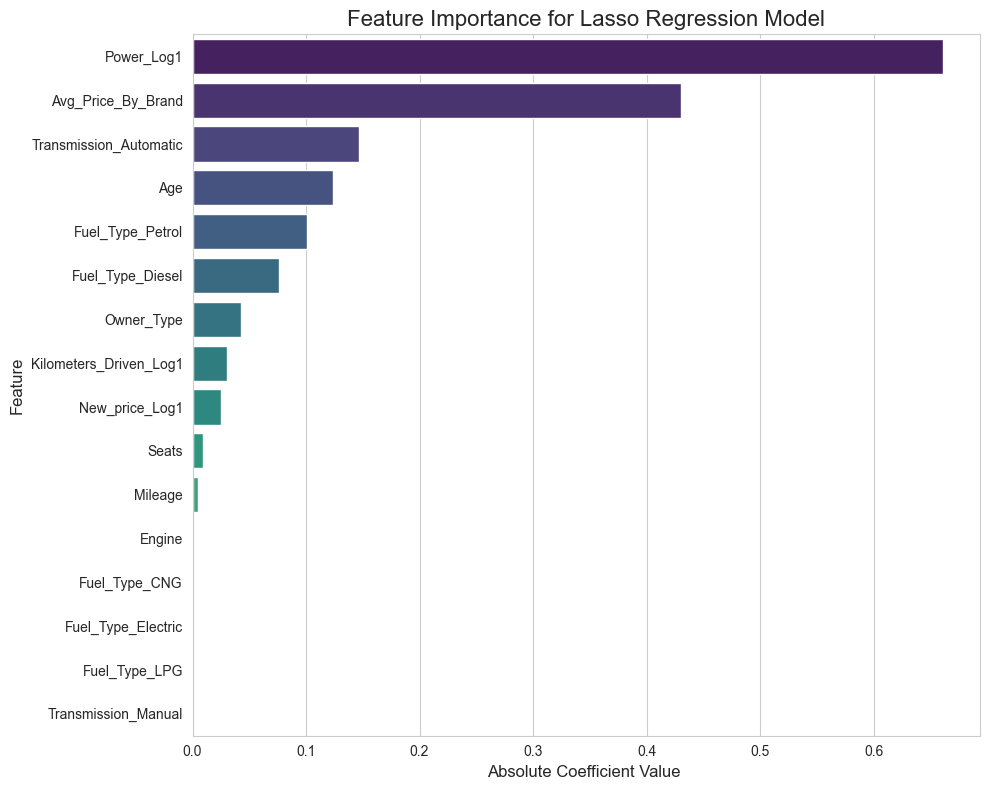

In [177]:
# --- Determine and Plot Feature Importance ---

# Create a DataFrame of feature names and their coefficients' absolute values
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': np.abs(lasso.coef_)
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Lasso Regression Model', fontsize=16)
plt.xlabel('Absolute Coefficient Value ', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() # Adjust layout to make sure labels fit
plt.show()


Observations:

- This output clearly shows you which features the Lasso model considered important enough to keep for making predictions and which it deemed irrelevant, effectively simplifying your model. 
- Power_Log1, Avg_Price_By_Brand, Transmission_Automatic still represent a good feature for both Linear Regression and Lasso to predict car prices 

### **Decision Tree**


In [178]:
dtr = DecisionTreeRegressor(random_state=42)

# Train the model on your processed training data
dtr.fit(X_train_processed, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


#### Model Evaluation  🧐


In [179]:
# --- Evaluate Training Performance ---
train_perf_dtr = model_performance_regression(dtr, X_train_processed, y_train)
train_perf_dtr['Model Name'] = 'train_perf_dtr'
print("Decision Tree - Training Performance:")
print(train_perf_dtr)

# --- Evaluate Testing Performance ---
test_perf_dtr = model_performance_regression(dtr, X_test_processed, y_test)
test_perf_dtr['Model Name'] = 'test_perf_dtr'
print("\nDecision Tree - Testing Performance:")
print(test_perf_dtr)

Decision Tree - Training Performance:
       RMSE       MAE  R-squared  Adj. R-squared      MAPE      Model Name
0  0.010052  0.000749   0.999866        0.999865  0.034849  train_perf_dtr

Decision Tree - Testing Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE     Model Name
0  0.315104  0.217458    0.87434        0.873216   inf  test_perf_dtr


In [180]:
model_metrics.extend([test_perf_dtr])
model_metrics

[       RMSE     MAE  R-squared  Adj. R-squared  MAPE    Model Name
 0  0.279265  0.2086   0.901299        0.900416   inf  test_perf_lr,
        RMSE      MAE  R-squared  Adj. R-squared  MAPE       Model Name
 0  0.280141  0.20918   0.900678         0.89979   inf  test_perf_lasso,
        RMSE       MAE  R-squared  Adj. R-squared  MAPE     Model Name
 0  0.315104  0.217458    0.87434        0.873216   inf  test_perf_dtr]

#### Making Predictions


In [181]:
# --- Evaluate on the original price scale (for MAE) ---
# Inverse transform both actual and predicted values
# Use the trained model to make predictions on the test set
y_pred_test = dtr.predict(X_test_processed)
y_test_original = np.expm1(y_test)
y_pred_test_original = np.expm1(y_pred_test)

mae_test = mean_absolute_error(y_test_original, y_pred_test_original)

# Print the result in a user-friendly way
print(f"Test Mean Absolute Error (MAE): ${mae_test:,.2f}")
print(f"\nOn average, the model's price prediction is off by about ${mae_test:,.0f}.")

Test Mean Absolute Error (MAE): $1.97

On average, the model's price prediction is off by about $2.


#### Feature Importance


In [182]:
# Create a DataFrame to view the coefficients
coefficients_dtr = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Coefficient': dtr.feature_importances_
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Model Coefficients ---")
print(coefficients_dtr.sort_values(by='Coefficient', ascending=False))


--- Model Coefficients ---
                   Feature  Coefficient
6               Power_Log1     0.580546
7                      Age     0.227459
8       Avg_Price_By_Brand     0.091551
2                   Engine     0.045268
4   Kilometers_Driven_Log1     0.024396
1                  Mileage     0.013523
5           New_price_Log1     0.004278
0               Owner_Type     0.004170
3                    Seats     0.003679
14  Transmission_Automatic     0.002447
13        Fuel_Type_Petrol     0.001405
10        Fuel_Type_Diesel     0.000757
15     Transmission_Manual     0.000412
9            Fuel_Type_CNG     0.000101
12           Fuel_Type_LPG     0.000007
11      Fuel_Type_Electric     0.000000


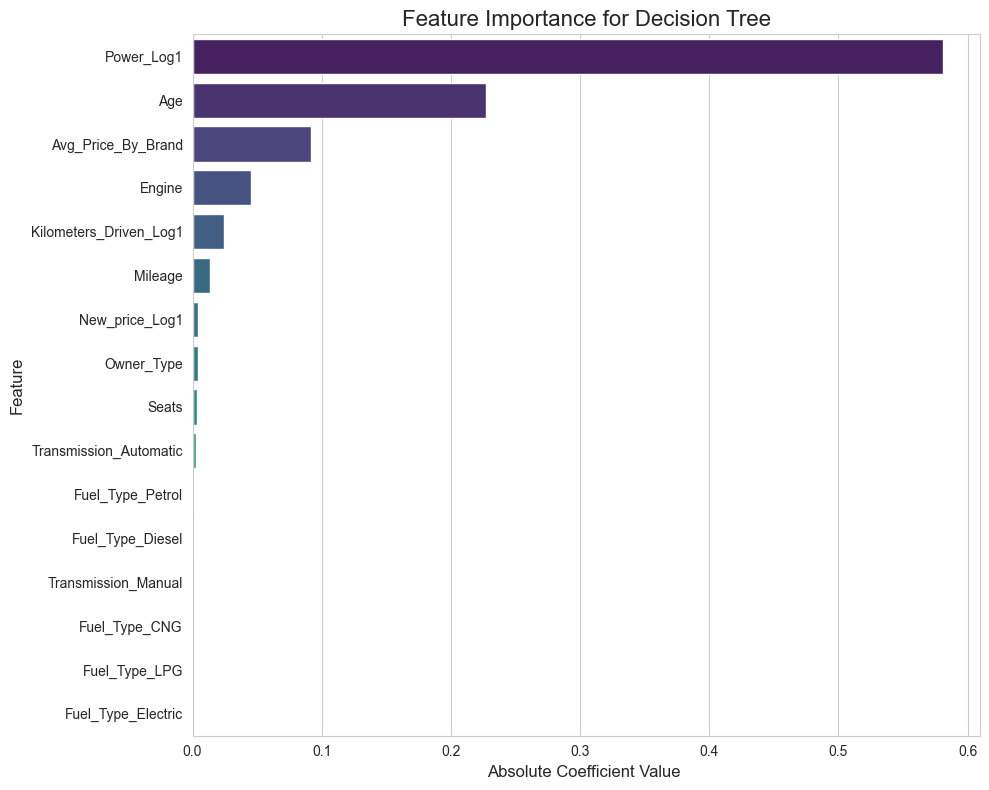

In [183]:
# Extract Feature Importances

# --- Determine and Plot Feature Importance ---

# Create a DataFrame of feature names and their coefficients' absolute values
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': np.abs(dtr.feature_importances_)
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Decision Tree', fontsize=16)
plt.xlabel('Absolute Coefficient Value ', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() # Adjust layout to make sure labels fit
plt.show()

#### Controlling Overfitting with Pruning

In [184]:
# Create a pruned Decision Tree to prevent overfitting
dtr_pruned = DecisionTreeRegressor(max_depth=7, random_state=42)

# Train the new, simpler model
dtr_pruned.fit(X_train_processed, y_train)

# --- Evaluate the Pruned Tree's Performance ---
print("\n--- Pruned Decision Tree Performance ---")
train_perf_pruned = model_performance_regression(dtr_pruned, X_train_processed, y_train)
train_perf_pruned['Model Name'] = 'train_perf_pruned'
print("Pruned Tree - Training Performance:")
print(train_perf_pruned)

test_perf_dtr_pruned = model_performance_regression(dtr_pruned, X_test_processed, y_test)
test_perf_dtr_pruned['Model Name'] = 'test_perf_dtr_pruned'
print("\nPruned Tree - Testing Performance:")
print(test_perf_dtr_pruned)


--- Pruned Decision Tree Performance ---
Pruned Tree - Training Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE         Model Name
0  0.239032  0.185157   0.924076        0.923786   inf  train_perf_pruned

Pruned Tree - Testing Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE            Model Name
0  0.294885  0.213563   0.889949        0.888964   inf  test_perf_dtr_pruned


In [185]:
model_metrics.extend([test_perf_dtr_pruned])


##### **Hyperparameter Tuning: Decision Tree**


In [186]:
# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [5, 7, 10, 15, None], # Max levels in the tree
    'min_samples_leaf': [2, 5, 10, 15], # Min samples required at a leaf node
    'min_samples_split': [2, 5, 10, 20], # Min samples required to split a node
    'max_features': ['sqrt', 'log2', None] # Number of features to consider for best split
}

In [187]:


# Create an instance of the Decision Tree model
dtr_tuned = DecisionTreeRegressor(random_state=42)

# Create the RandomizedSearchCV object
# n_iter: number of random combinations to try
# cv: number of cross-validation folds
# n_jobs=-1: use all available CPU cores to speed up
random_search = RandomizedSearchCV(
    estimator=dtr_tuned,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# This will run the search on your training data
random_search.fit(X_train_processed, y_train)

,estimator,DecisionTreeR...ndom_state=42)
,param_distributions,"{'max_depth': [5, 7, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [2, 5, ...], 'min_samples_split': [2, 5, ...]}"
,n_iter,20
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


##### Model Evaluation  🧐

In [188]:
# Print the best hyperparameters found
print("Best Hyperparameters found:", random_search.best_params_)
# Get the best model
best_dtr_tuned = random_search.best_estimator_

Best Hyperparameters found: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': None}


In [189]:
# --- Evaluate Training Performance ---
train_perf_dtr_tuned = model_performance_regression(best_dtr_tuned, X_train_processed, y_train)
print("Random Forest - Training Performance:")
print(train_perf_dtr_tuned)

# Evaluate the best model on the test set
test_perf_dtr_tuned = model_performance_regression(best_dtr_tuned, X_test_processed, y_test)
test_perf_dtr_tuned['Model Name'] = 'test_perf_dtr_tuned'
print("\nTuned Decision Tree - Testing Performance:")
print(test_perf_dtr_tuned)

Random Forest - Training Performance:
      RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.16666  0.122269   0.963091         0.96295   inf

Tuned Decision Tree - Testing Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE           Model Name
0  0.283834  0.199509   0.898043        0.897131   inf  test_perf_dtr_tuned


In [190]:
model_metrics.extend([test_perf_dtr_tuned])

Observations:

- Now, I can see that the training and testing scores are much closer together, indicating a more robust model that generalizes better. Finding the optimal max_depth is a process of experimentation with hyperparameter tuning.

##### Making Predictions

In [191]:
# --- Evaluate on the original price scale (for MAE) ---
# Inverse transform both actual and predicted values
# Use the trained model to make predictions on the test set
y_pred_test = best_dtr_tuned.predict(X_test_processed)
y_test_original = np.expm1(y_test)
y_pred_test_original = np.expm1(y_pred_test)

mae_test = mean_absolute_error(y_test_original, y_pred_test_original)

# Print the result in a user-friendly way
print(f"Test Mean Absolute Error (MAE): ${mae_test:,.2f}")
print(f"\nOn average, the model's price prediction is off by about ${mae_test:,.0f}.")

Test Mean Absolute Error (MAE): $1.94

On average, the model's price prediction is off by about $2.


##### Feature Importance

In [192]:
# Create a DataFrame to view the coefficients
coefficients_dtr_tuned = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Coefficient': best_dtr_tuned.feature_importances_,
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Model Coefficients ---")
print(coefficients_dtr_tuned.sort_values(by='Coefficient', ascending=False))


--- Model Coefficients ---
                   Feature  Coefficient
6               Power_Log1     0.601236
7                      Age     0.233076
8       Avg_Price_By_Brand     0.092375
2                   Engine     0.044624
1                  Mileage     0.009711
4   Kilometers_Driven_Log1     0.009493
5           New_price_Log1     0.002811
3                    Seats     0.002492
15     Transmission_Manual     0.001055
14  Transmission_Automatic     0.001054
13        Fuel_Type_Petrol     0.000963
0               Owner_Type     0.000956
10        Fuel_Type_Diesel     0.000155
9            Fuel_Type_CNG     0.000000
11      Fuel_Type_Electric     0.000000
12           Fuel_Type_LPG     0.000000


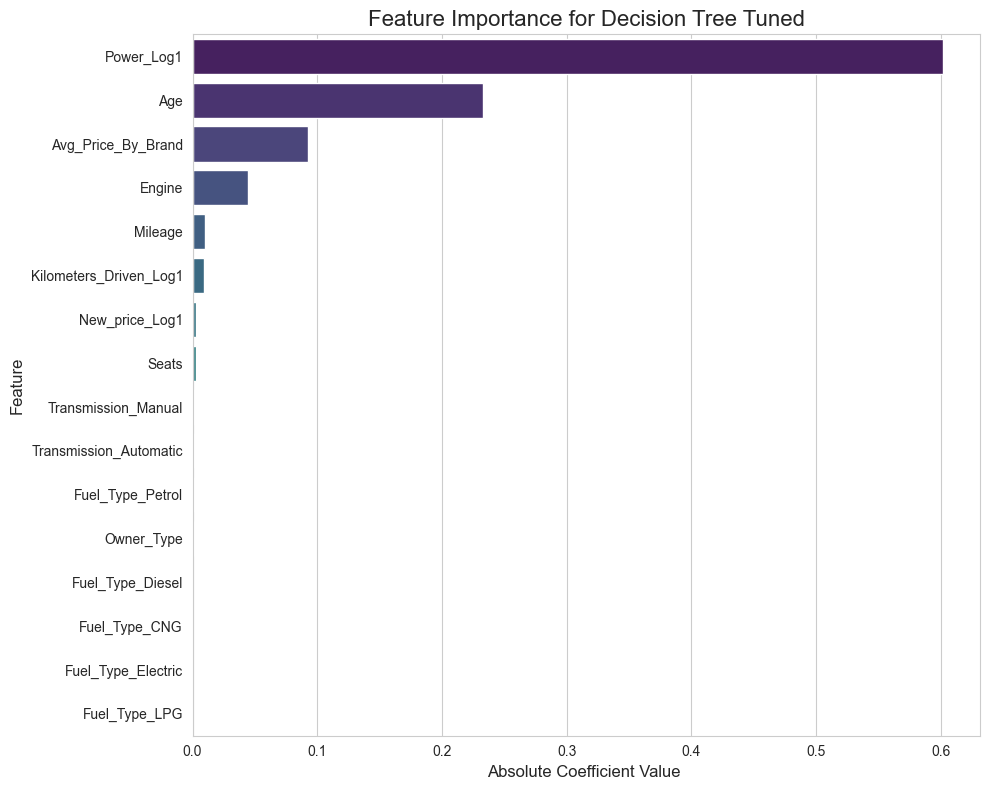

In [193]:
# Extract Feature Importances

# --- Determine and Plot Feature Importance ---

# Create a DataFrame of feature names and their coefficients' absolute values
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': np.abs(best_dtr_tuned.feature_importances_)
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Decision Tree Tuned', fontsize=16)
plt.xlabel('Absolute Coefficient Value ', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() # Adjust layout to make sure labels fit
plt.show()

### **Random Forest**


In [194]:
# Create an instance of the Random Forest model
# n_jobs=-1 uses all available CPU cores to speed up training
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)


# Train the model on your processed training data
rf.fit(X_train_processed, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Model Evaluation  🧐

In [195]:
# --- Evaluate Training Performance ---
train_perf_rf = model_performance_regression(rf, X_train_processed, y_train)
print("Random Forest - Training Performance:")
print(train_perf_rf)

# --- Evaluate Testing Performance ---
test_perf_rf = model_performance_regression(rf, X_test_processed, y_test)
test_perf_rf['Model Name'] = 'test_perf_rf'
print("\nRandom Forest - Testing Performance:")
print(test_perf_rf)

Random Forest - Training Performance:
      RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.08142  0.059265   0.991191        0.991157   inf

Random Forest - Testing Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE    Model Name
0  0.242887  0.165086   0.925338        0.924671   inf  test_perf_rf


In [196]:
model_metrics.extend([test_perf_rf])


#### Making Predictions

In [197]:
# --- Evaluate on the original price scale (for MAE) ---
# Inverse transform both actual and predicted values
# Use the trained model to make predictions on the test set
y_pred_test = rf.predict(X_test_processed)
y_test_original = np.expm1(y_test)
y_pred_test_original = np.expm1(y_pred_test)

mae_test = mean_absolute_error(y_test_original, y_pred_test_original)

# Print the result in a user-friendly way
print(f"Test Mean Absolute Error (MAE): ${mae_test:,.2f}")
print(f"\nOn average, the model's price prediction is off by about ${mae_test:,.0f}.")

Test Mean Absolute Error (MAE): $1.55

On average, the model's price prediction is off by about $2.


#### Feature Importance 

In [198]:
# Create a DataFrame to view the coefficients
coefficients_rf = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Coefficient': rf.feature_importances_,
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Model Coefficients ---")
print(coefficients_rf.sort_values(by='Coefficient', ascending=False))


--- Model Coefficients ---
                   Feature  Coefficient
6               Power_Log1     0.553588
7                      Age     0.228132
8       Avg_Price_By_Brand     0.120582
2                   Engine     0.040792
4   Kilometers_Driven_Log1     0.023595
1                  Mileage     0.015783
5           New_price_Log1     0.004425
3                    Seats     0.004105
0               Owner_Type     0.003243
10        Fuel_Type_Diesel     0.001590
14  Transmission_Automatic     0.001503
15     Transmission_Manual     0.001369
13        Fuel_Type_Petrol     0.001129
9            Fuel_Type_CNG     0.000093
11      Fuel_Type_Electric     0.000050
12           Fuel_Type_LPG     0.000022


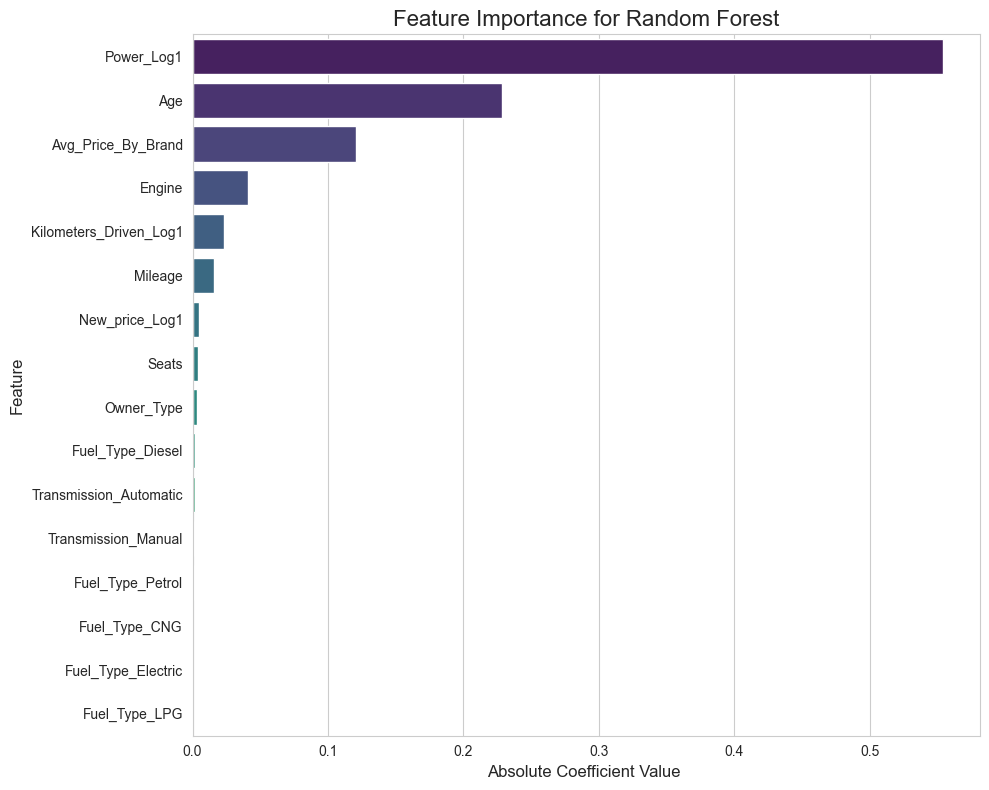

In [199]:
# Extract Feature Importances

# --- Determine and Plot Feature Importance ---

# Create a DataFrame of feature names and their coefficients' absolute values
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': np.abs(rf.feature_importances_)
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Random Forest', fontsize=16)
plt.xlabel('Absolute Coefficient Value ', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() # Adjust layout to make sure labels fit
plt.show()

### **Hyperparameter Tuning: Random Forest**

In [200]:
# Define the hyperparameter grid to search
# This grid is specific to Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],          # Number of trees in the forest
    'max_depth': [7, 10, 15],                  # Max levels in each tree
    'min_samples_leaf': [2, 5, 10],            # Min samples required at a leaf node
    'max_features': ['sqrt', 1.0]              # Number of features to consider for best split ('sqrt' or all)
}

In [201]:
# Create a base Random Forest model instance
rf_tuned = RandomForestRegressor(random_state=42, n_jobs=-1)

# Create the RandomizedSearchCV object
# We'll try 10 different combinations (n_iter=10)
random_search_rf = RandomizedSearchCV(
    estimator=rf_tuned,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Run the search on your training data
random_search_rf.fit(X_train_processed, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [7, 10, ...], 'max_features': ['sqrt', 1.0], 'min_samples_leaf': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,n_iter,10
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [202]:
# Print the best hyperparameters found
print("Best Hyperparameters for Random Forest:", random_search_rf.best_params_)

# Get the best, tuned model
best_rf_model = random_search_rf.best_estimator_

Best Hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 1.0, 'max_depth': 15}


#### Model Evaluation  🧐

In [203]:
# --- Evaluate Training Performance ---
train_perf_rf_tuned = model_performance_regression(best_rf_model, X_train_processed, y_train)
print("Random Forest - Training Performance:")
print(train_perf_rf_tuned)

# Evaluate the best model on the test set
test_perf_rf_tuned = model_performance_regression(best_rf_model, X_test_processed, y_test)
test_perf_rf_tuned['Model Name'] = 'test_perf_rf_tuned'
print("\nTuned Decision Tree - Testing Performance:")
print(test_perf_rf_tuned)

Random Forest - Training Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE
0  0.167717  0.122945   0.962621        0.962479   inf

Tuned Decision Tree - Testing Performance:
       RMSE       MAE  R-squared  Adj. R-squared  MAPE          Model Name
0  0.246354  0.170463   0.923191        0.922504   inf  test_perf_rf_tuned


In [204]:
model_metrics.extend([test_perf_rf_tuned])

#### Making Predictions


In [205]:
# --- Evaluate on the original price scale (for MAE) ---
# Inverse transform both actual and predicted values
# Use the trained model to make predictions on the test set
y_pred_test = best_rf_model.predict(X_test_processed)
y_test_original = np.expm1(y_test)
y_pred_test_original = np.expm1(y_pred_test)

mae_test = mean_absolute_error(y_test_original, y_pred_test_original)

# Print the result in a user-friendly way
print(f"Test Mean Absolute Error (MAE): ${mae_test:,.2f}")
print(f"\nOn average, the model's price prediction is off by about ${mae_test:,.0f}.")

Test Mean Absolute Error (MAE): $1.59

On average, the model's price prediction is off by about $2.


#### **Feature Importance**

In [206]:
# Create a DataFrame to view the coefficients
coefficients_rf_tuned = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Coefficient': best_rf_model.feature_importances_,
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Model Coefficients ---")
print(coefficients_rf_tuned.sort_values(by='Coefficient', ascending=False))


--- Model Coefficients ---
                   Feature  Coefficient
6               Power_Log1     0.570180
7                      Age     0.234478
8       Avg_Price_By_Brand     0.122226
2                   Engine     0.040189
1                  Mileage     0.011639
4   Kilometers_Driven_Log1     0.011564
5           New_price_Log1     0.002379
3                    Seats     0.002225
14  Transmission_Automatic     0.001229
0               Owner_Type     0.001078
15     Transmission_Manual     0.001034
10        Fuel_Type_Diesel     0.001008
13        Fuel_Type_Petrol     0.000765
9            Fuel_Type_CNG     0.000005
11      Fuel_Type_Electric     0.000000
12           Fuel_Type_LPG     0.000000


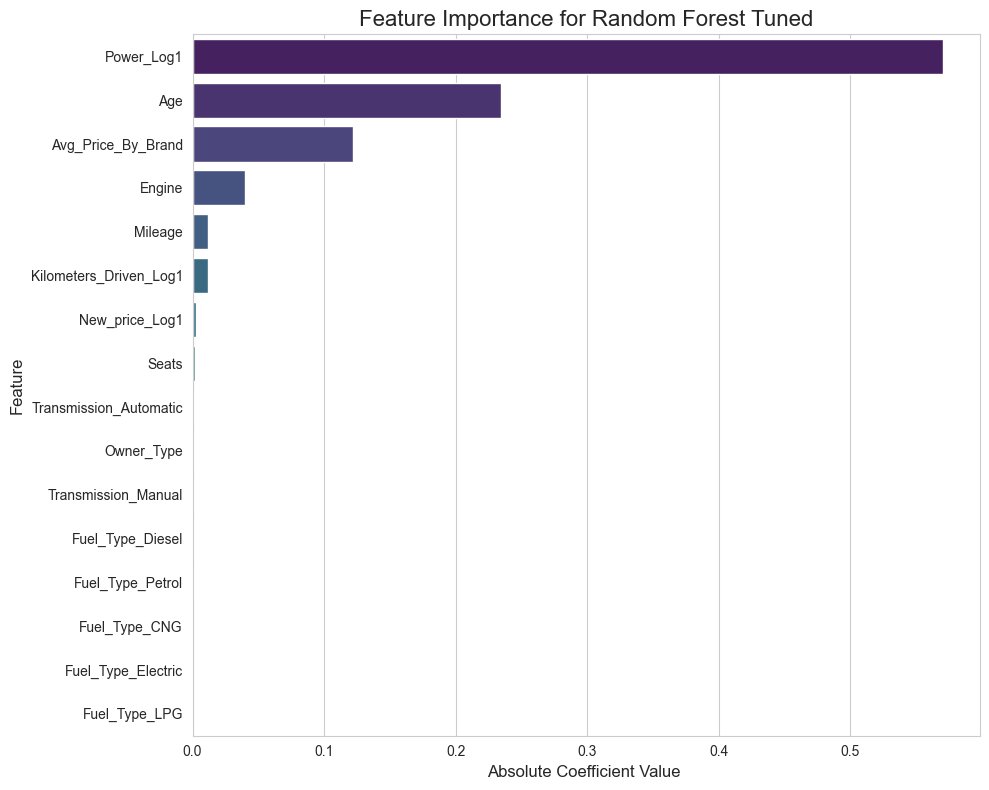

In [207]:
# Extract Feature Importances

# --- Determine and Plot Feature Importance ---

# Create a DataFrame of feature names and their coefficients' absolute values
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': np.abs(best_rf_model.feature_importances_)
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Random Forest Tuned', fontsize=16)
plt.xlabel('Absolute Coefficient Value ', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() # Adjust layout to make sure labels fit
plt.show()

## **Evaluation a crossed models** 

In [208]:
## **Evaluation across Models**
model_metrics = pd.concat(model_metrics, axis=0).set_index(['Model Name'])
model_metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Model Name,,,,,
test_perf_lr,0.279265,0.208600,0.901299,0.900416,inf
test_perf_lasso,0.280141,0.209180,0.900678,0.899790,inf
test_perf_dtr,0.315104,0.217458,0.874340,0.873216,inf
test_perf_dtr_pruned,0.294885,0.213563,0.889949,0.888964,inf
test_perf_dtr_tuned,0.283834,0.199509,0.898043,0.897131,inf
test_perf_rf,0.242887,0.165086,0.925338,0.924671,inf
test_perf_rf_tuned,0.246354,0.170463,0.923191,0.922504,inf


## **Conclusions and Recommendations**

### **Metric Selection** 📐
- RMSE (Root Mean Squared Error):  It measures the average magnitude of the errors. The "squared" part of the calculation ***gives larger errors disproportionately more weight. This is important in a price prediction scenario because being significantly off on the price of an expensive car is a much bigger problem than being slightly off on a cheap car. RMSE penalizes these larger errors more heavily,*** which aligns well with the business goal of minimizing significant pricing mistakes.

### **Proposal for the final solution design:** 

- What model do you propose to be adopted? Why is this the best solution to adopt?
    - R-squared (Coefficient of Determination): This metric tells the proportion of the variance in the dependent variable (car price) that is predictable from the independent variables (the features of the car). An R-squared of 0.925 means that about 92.5% of the variation in car prices can be explained by your model. This is a great measure of how well your model fits the overall data. A higher R-squared indicates a better fit.Based on the evaluation metrics, the Random Forest model (rf) appears to be the best model for predicting car prices. It has the lowest RMSE and MAE on the test set, indicating that its predictions are closest to the actual prices on average. The R-squared and Adj R-squared values is also high, suggesting that a large portion of the variance in car prices is explained by the model and large proporcion of the variance the model explains relative to the number of predictors I used..

**Comparison of various techniques and their relative performance based on chosen Metric (Measure of success):** 
- How do different techniques perform? Which one is performing relatively better? 
    - Random Forest (rf) performed the best among all the models, with the lowest RMSE (0.242887) and MAE (0.165086), and the highest R-squared (0.925338). This indicates that it has the best predictive accuracy on unseen data.The tuned Random Forest (test_perf_rf_tuned) also performed well, very close to the un-tuned version.
    - Linear Regression (test_perf_lr) and Lasso (test_perf_lasso) had similar performance, but were not as accurate as the Random Forest models.
    - The Decision Tree (test_perf_dtr) showed signs of overfitting, with a much better performance on the training set than the test set. Pruning and tuning helped improve its performance on the test set, but it still didn't reach the level of the Random Forest models.

- Is there scope to improve the performance further?
    - More Advanced Feature Engineering: Explore creating more complex features, perhaps interactions between existing features (e.g., Age * Kilometers_Driven) or features derived from the Name column that capture more granular model variations.
    - Handling Outliers: While you identified outliers, a more sophisticated approach to handling them in numerical features (beyond just log transformation or clipping) might improve performance.
    - Exploring Other Models: Consider trying other powerful regression models like Gradient Boosting (e.g., XGBoost, LightGBM) which often perform very well on structured data.
    - Cross-Validation: While you used cross-validation in hyperparameter tuning, a more extensive cross-validation strategy during model evaluation could provide a more robust estimate of the model's performance.
    - More Extensive Hyperparameter Tuning: The hyperparameter tuning was done using RandomizedSearchCV with a limited number of iterations. A more exhaustive search (like GridSearchCV if computationally feasible) or a larger number of iterations with RandomizedSearchCV could potentially find better hyperparameter combinations.
    - Ensemble Methods: Combining predictions from multiple models (averaging the predictions of the best performing models) can sometimes lead to improved performance. Overall, the Random Forest model is a strong performer for this task. Further improvements would likely involve more in-depth feature engineering and exploring other advanced modelingg techniques.

**Refined insights:** 
- What are the most meaningful insights relevant to the problem? 
    - Depreciation is Primarily Driven by Age and Kilometers Driven: The analysis clearly showed a strong negative correlation between a car's price and its age and the total kilometers it has been driven. These two factors are the most significant indicators of wear and tear and are fundamental to how cars depreciate in value.
    - Performance and Size (Power and Engine) are Key Value Drivers: Cars with higher engine power (BHP) and larger engine displacement (CC) generally command higher prices. This reflects market demand for performance and capability.
    - Vehicle History (Owner Type) Matters Significantly: The number of previous owners has a clear impact on price, with first-owner cars being the most valuable. This highlights the importance buyers place on a car's history and perceived maintenance.
    - Brand Reputation and Market Positioning are Captured by Average Price: The Avg_Price_By_Brand feature, derived from the average price of cars for each brand in the training data, proved to be a highly important predictor. This indicates that the brand of a car significantly influences its resale value, acting as a proxy for quality, reliability, and market desirability.
    - Fuel Type and Transmission Influence Price: While not as dominant as age or power, the type of fuel the car uses and its transmission type also contribute to the price prediction. This reflects differences in running costs, performance characteristics, and market preferences for these options.
    - Data Quality (Missing Values) is a Challenge: The presence of a significant number of missing values in key columns like New_price, Power, Engine, and Seats required careful handling (imputation and dropping rows for the target variable). Addressing data quality is crucial for building reliable models.
    - Tree-Based Models Capture Complex Relationships Well: The Random Forest model, a tree-based ensemble method, outperformed linear models. This suggests that the relationship between the car features and price is likely non-linear and involves complex interactions that tree-based models are better equipped to capture. 

Questions:

While imputation is a valuable technique for handling missing data, it is not appropriate for the target variable in a supervised learning problem. 
- Dropping those rows ensures that your model is trained and evaluated on instances where the true outcome is known, leading to a more reliable and trustworthy model. In this specific case with the 'Price' column, dropping the rows with missing prices was the correct approach to ensure the integrity of the training and evaluation process.

### **Recommendations for Implementation** 📓


Key factors like vehicle age, mileage, power, and brand should be highlighted to both sellers and buyers. Further improvements can be explored through more advanced feature engineering, exploring other models, and continuous model monitoring and retraining with new market data.

Impact: Implementing this solution will provide with a critical competitive advantage, fostering trust among users, facilitating smoother transactions, and ultimately driving business growth in the used car market. 

- Leverage the Pricing Model: The trained Random Forest model provides a strong foundation for a "fair price" calculator. The company should integrate this model into their platform to provide data-driven price estimates to both sellers and buyers. **This transparency will be a key differentiator and build trust.**
- Highlight Key Value Drivers: The analysis shows that Power_Log1, Age, and Avg_Price_By_Brand are the most influential factors in determining car prices. The company should emphasize these factors in their listings and marketing. For example, they could highlight the horsepower and age of a car, and the average resale value of the brand.
- Educate Sellers on Pricing: Given the strong influence of Age and Kilometers_Driven_Log1 (even though less important than Power and Age), The company can educate sellers on how these factors impact their car's value. Providing realistic price expectations upfront can lead to faster sales and more satisfied sellers.
- Focus on First and Second Owner Cars: The Owner_Type analysis clearly shows that cars with fewer owners command higher prices. The company could consider focusing their acquisition efforts on sourcing more first and second owner vehicles to attract buyers looking for lower risk and potentially better-maintained cars.
- Provide Insights on Fuel Type and Transmission: The models show that Fuel_Type and Transmission also influence price. The company can provide buyers with information on the potential running costs and market demand associated with different fuel types and transmissions to help them make informed decisions.
- Data Collection Improvement: The New_price column had a significant number of missing values. While imputation was performed, collecting more complete data on the original price of new cars would likely further improve model accuracy, as it's a strong indicator of the car's initial value and depreciation potential.
- Expand Geographic Reach Strategically: The Location analysis showed differences in pricing across cities. As The company expands, they should consider these regional price variations and tailor their pricing strategies accordingly.
- Monitor and Retrain the Model: The used car market is dynamic. The company should continuously monitor the model's performance and retrain it periodically with new data to ensure its predictions remain accurate over time.
By implementing these recommendations, The company can use the insights from this analysis to build a more transparent, trustworthy, and efficient used car marketplace.

### Key Risk and Challenges 

key risks and challenges associated with building and deploying a used car price prediction model:

* Data Quality and Completeness: The analysis identified missing values in several important features. While imputation was performed, incomplete or inaccurate data can limit the model's accuracy. Ensuring a continuous flow of high-quality, complete data is crucial.
* Data Drift: The used car market is constantly changing due to new models, economic conditions, fuel price fluctuations, and shifts in consumer preferences. The model trained on historical data may become less accurate over time (data drift). Regular monitoring and retraining are essential.
* Regional Variations in Pricing (India): While 'Location' was included and analyzed, local market conditions, taxes, and demand can significantly impact prices. The current location handling (dropping it after target encoding BrandName) might not fully capture these nuances. More granular location data or location-specific models might be needed.
Rare Car Models and Low-Frequency Categories: The dataset has a high cardinality in the 'Name' and 'BrandModel' features, with many unique values and some with very low frequencies. This can make it challenging for the model to accurately predict prices for less common cars.
* Impact of External Factors: Unforeseen events (like a sudden change in fuel prices, government regulations,tariff,  or natural disasters) can significantly impact the used car market in ways that the model, trained on historical data, may not anticipate.
* Subjectivity in Car Condition: The dataset lacks information on the specific condition of individual cars (e.g., wear and tear beyond mileage, accident history, maintenance records). This subjective element is a major factor in real-world pricing and is difficult to capture with structured data alone. The model predicts a "fair price" based on the provided features but cannot account for a specific car's unique condition.
* Market Manipulation/Strategic Pricing: Sellers may strategically price their cars above or below the "fair price" for various reasons. The model predicts a market-based price, but real-world transactions can deviate.
* Model Interpretability: While tree-based models like Random Forest provide feature importance, understanding the exact reasoning behind a specific price prediction can be complex compared to simpler linear models. Explaining the model's output to users (both sellers and buyers) in an understandable way is important for building trust.
* Implementation Challenges: Integrating the model into the platform, ensuring real-time predictions, and maintaining the infrastructure require technical expertise and resources tht we should consider.

## Solution Summary 💡

Recap the Problem: The used car market suffers from significant price uncertainty, creating distrust for both buyers and sellers. the company, aims to build trust and gain market share by providing a reliable "fair price" calculator.The proposed solution involves building a machine learning model to predict used car prices,  this process includes:

 - Data Loading and Exploration (EDA): Understanding the dataset, identifying key features, exploring distributions, and noting missing values and outliers.
 - Data Preprocessing: Handling missing values through imputation (using mean, median, or mode as appropriate) and dropping rows with missing target values. Engineering new features like 'Age' from the 'Year' and extracting 'BrandName' and 'BrandModel' from the 'Name'. 
  - Handling categorical features using Target Encoding for 'BrandName' and One-Hot Encoding for others like 'Fuel_Type' and 'Transmission', and Ordinal Encoding for 'Owner_Type'. Applying log transformations to skewed numerical features to normalize their distributions.
- Model Building: Training various regression models (Linear Regression, Lasso, Decision Tree, and Random Forest) on the prepared data.
- Model Evaluation and Tuning: Assessing model performance using metrics like RMSE, MAE, and R-squared on a test set. Hyperparameter tuning using Randomized Search to optimize model performance and prevent overfitting.
- Model Selection: Identifying the best-performing model based on evaluation metrics. The Random Forest model emerged as the most accurate predictor, demonstrating strong performance on the test set.
By implementing the Random Forest model as the core of the "fair price" calculator, The company can provide a data-driven and trustworthy tool that benefits both sellers and buyers, establishing itself as a credible platform in the market.

In [209]:
model_metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Model Name,,,,,
test_perf_lr,0.279265,0.208600,0.901299,0.900416,inf
test_perf_lasso,0.280141,0.209180,0.900678,0.899790,inf
test_perf_dtr,0.315104,0.217458,0.874340,0.873216,inf
test_perf_dtr_pruned,0.294885,0.213563,0.889949,0.888964,inf
test_perf_dtr_tuned,0.283834,0.199509,0.898043,0.897131,inf
test_perf_rf,0.242887,0.165086,0.925338,0.924671,inf
test_perf_rf_tuned,0.246354,0.170463,0.923191,0.922504,inf


['test_perf_lr',
 'test_perf_lasso',
 'test_perf_dtr',
 'test_perf_dtr_pruned',
 'test_perf_dtr_tuned',
 'test_perf_rf',
 'test_perf_rf_tuned']

In [110]:
def check_coefficients_amongs_models(models_coefs: list):
    """
    Groups features from a DataFrame into positive and negative lists based on their coefficients.

    Args:
        model_coefficients: A pandas DataFrame list with 'Feature' and 'Coefficient' columns.

    Returns:
        A tuple containing two lists:
        - A list of features with positive or zero coefficients.
        - A list of features with negative coefficients.
    """
    for model_coef in models_coefs:
        # Filter for features with positive or zero coefficients
        positive_features = model_coef[model_coef['Coefficient'] >= 0]['Feature'].tolist()
    
        # Filter for features with negative coefficients
        negative_features = model_coef[model_coef['Coefficient'] < 0]['Feature'].tolist()
        
        coef_grp = {
            'Positive Feature':positive_features,
            'Negative Feature':negative_features
            }
                                   
        print(coef_grp)
        
    
        




In [111]:
check_coefficients_amongs_models(model_metrics.index.tolist())

{'Positive Feature': ['Fuel_Type_Electric', 'Power_Log1', 'Avg_Price_By_Brand', 'Transmission_Automatic', 'New_price_Log1', 'Seats', 'Engine'], 'Negative Feature': ['Mileage', 'Kilometers_Driven_Log1', 'Owner_Type', 'Transmission_Manual', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_LPG', 'Fuel_Type_CNG', 'Fuel_Type_Petrol']}


In [105]:
type(coefficients_lr)

pandas.core.frame.DataFrame

In [106]:
check_coefficients_amongs_models(coefficients_lr)

TypeError: string indices must be integers